# Code Associated with Research Question 1

__Research Question 1__ <br>
"Is there a change in the low-frequency power between _uncertain_ and _certain_ conditions?"

### 1. Compute Time-frequency Representation

- outliers are not removed
- NaNs are removed during preprocessing

Steps:
1. Iterate over all subjects
2. Compute time-frequency power
3. Cut baseline epochs and trial epochs
4. Baseline correct trial epochs
5. 

### Compute frequencies to use in logarithmic scale

In [ ]:
import numpy as np

fmin = 2
fmax = 128
fnum = 30

np.logspace(np.log10(fmin), np.log10(fmax), fnum)

### Center Frequencies and Number of Cycles for Complex Morelet Wavelet

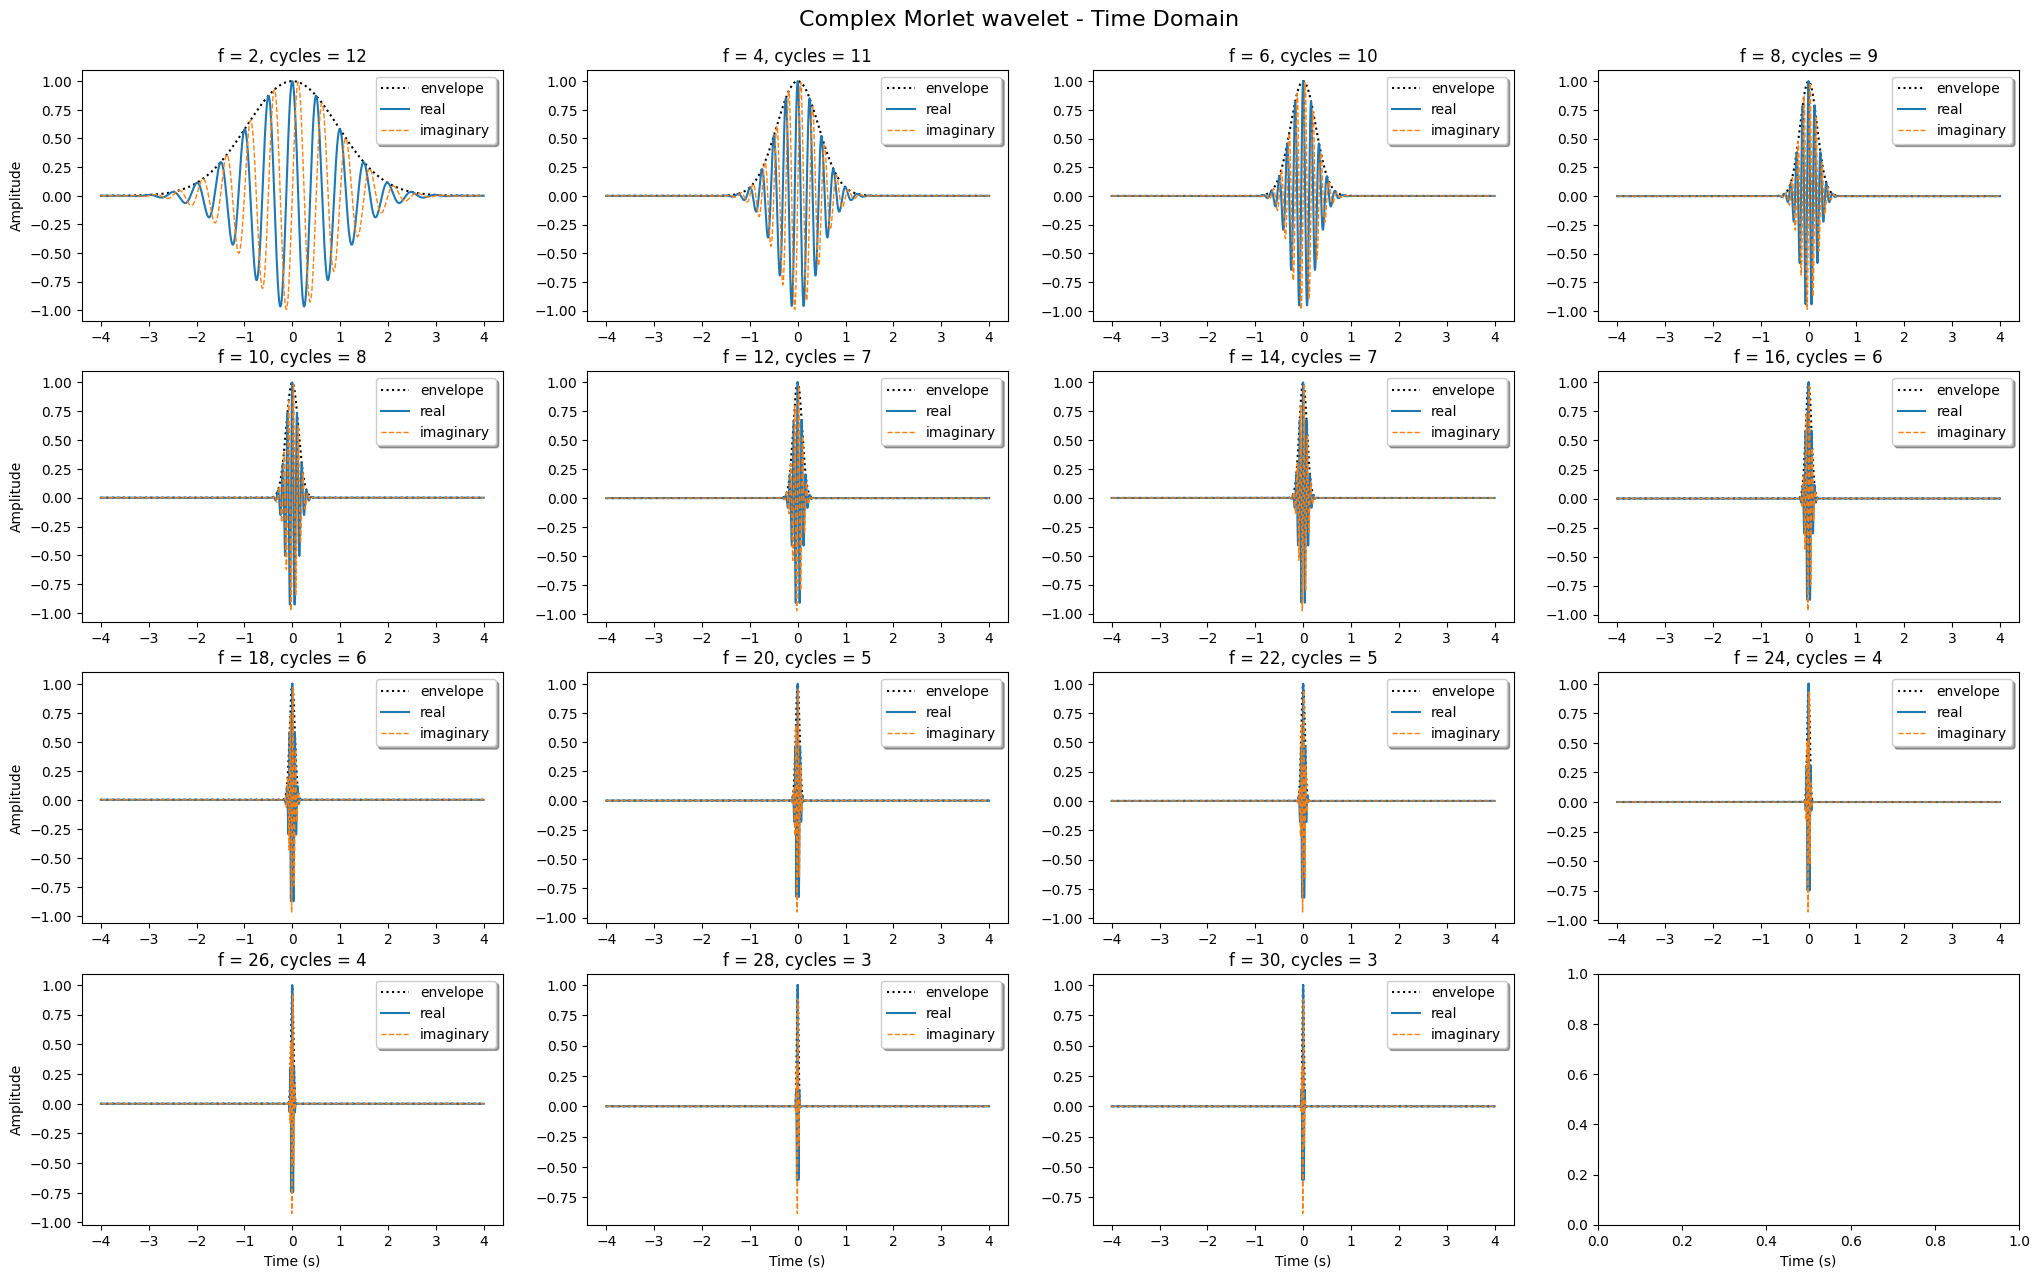

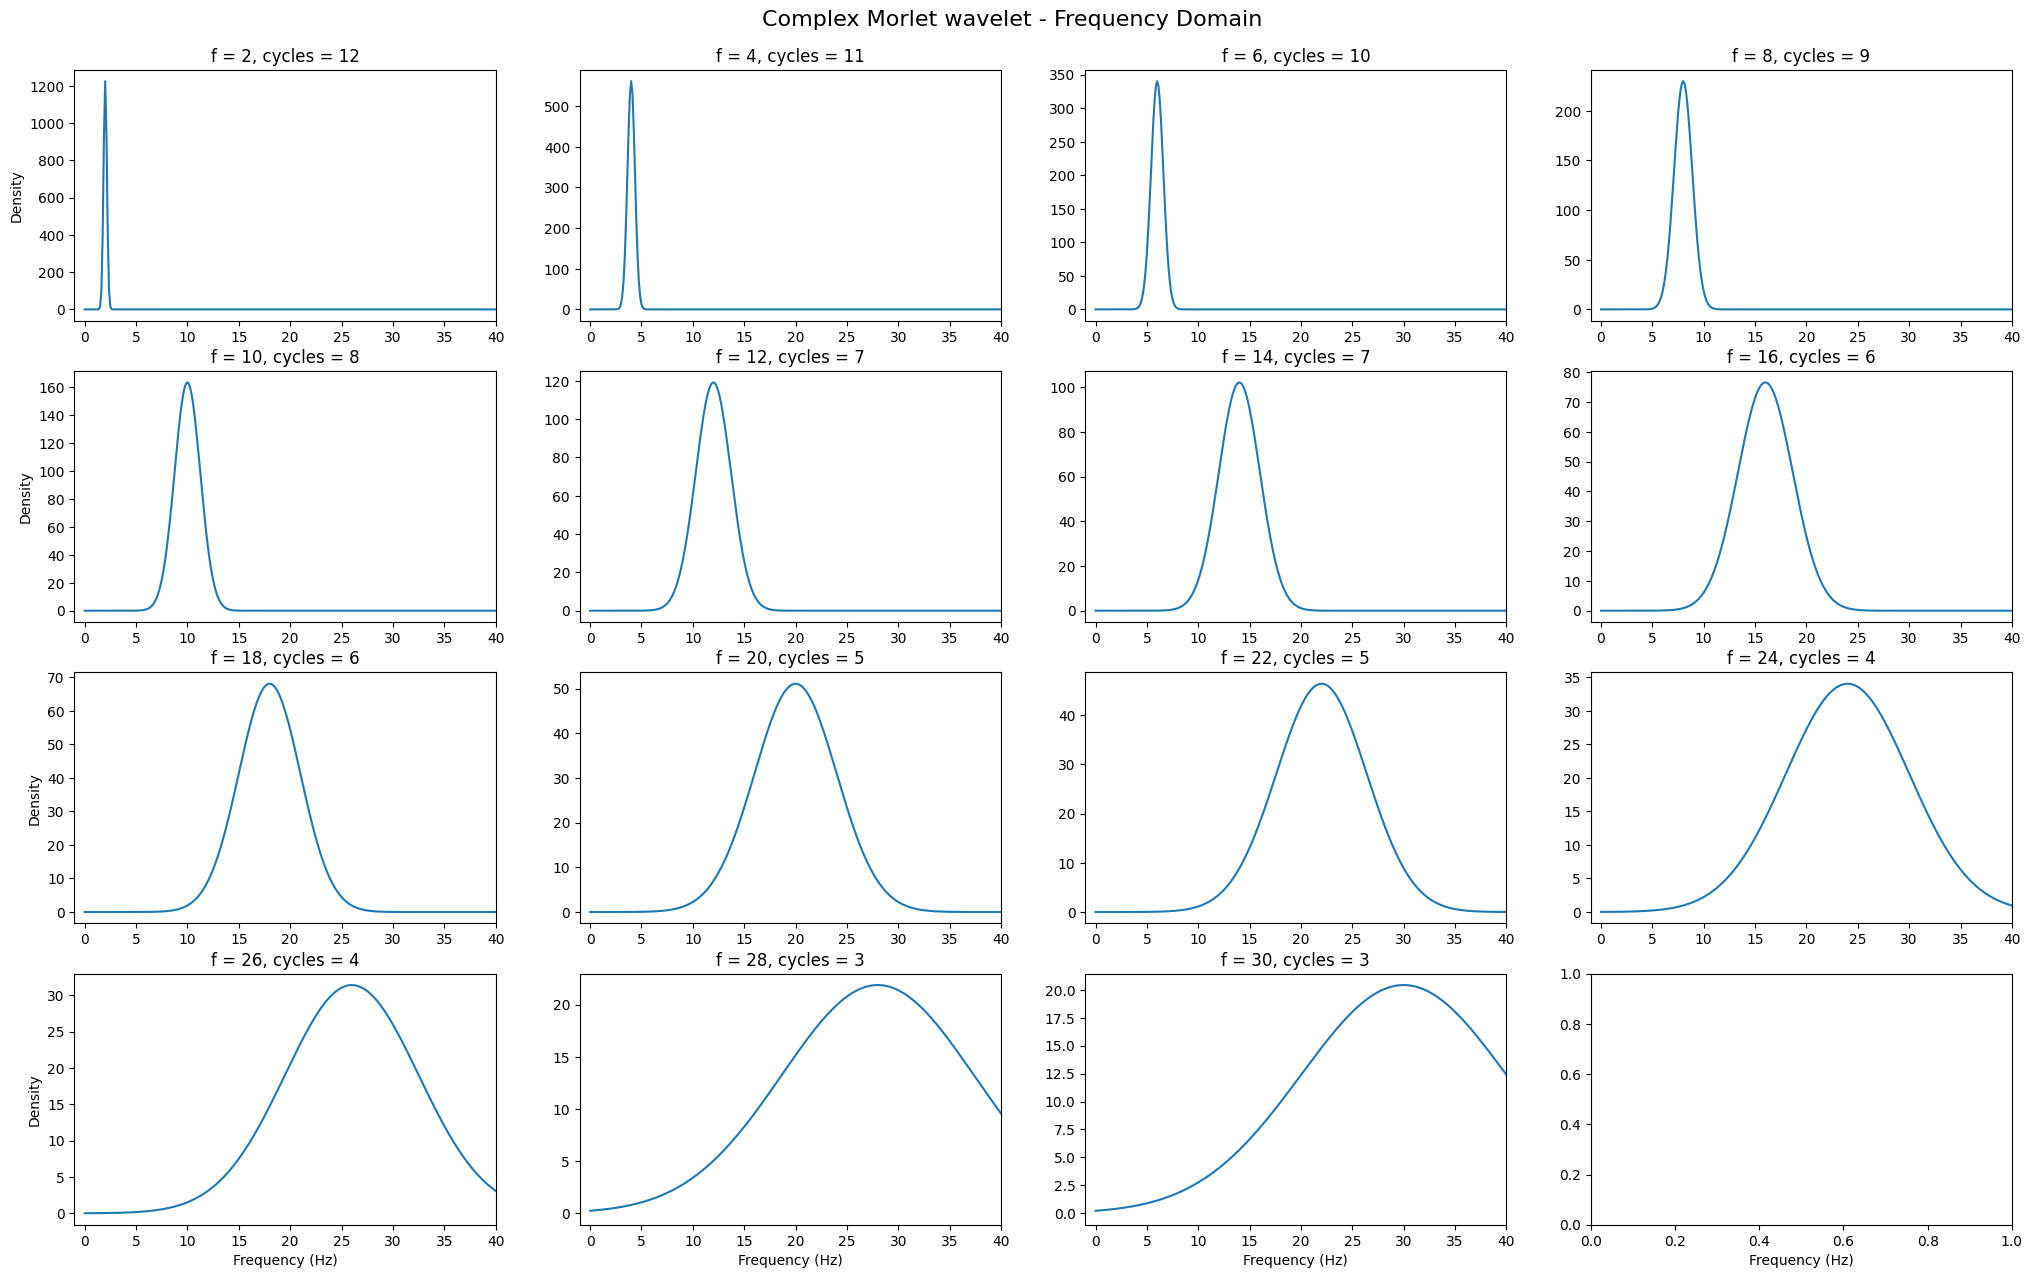

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import neuropsy.analysis as npsa


# ********* PARAMETERS ********* #
fs                          = 512
t_wl                        = np.arange(-4, 4+1/fs, 1/fs) # long enough time to capture the wavelet for given f and n
frequencies                 = np.arange(2, 32, 2)
cycles                      = np.insert(np.flipud(np.arange(3, 13, 1)), [-1, -2, -3, -4, -5], [3, 4, 5, 6, 7])

# ********* WAVELET AND PLOT ********* #
fig, ax = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)#, sharex=True, sharey=True)
fig2, ax2 = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)#, sharex=True, sharey=True)
ax = ax.flatten()
ax2 = ax2.flatten()

wavelet_funcs = {}
for i, (f, n) in enumerate(zip(frequencies, cycles)):

    # create complex Morlet wavelet
    wavelet, gauss_env = npsa.morlet(f, n, t_wl, return_gaussian=True)
    wavelet_funcs[f] = wavelet
    
    # plot wavelet and gaussian envelope
    ax[i].plot(t_wl, gauss_env, ':', label='envelope', color='black')
    ax[i].plot(t_wl, wavelet.real, label='real')
    ax[i].plot(t_wl, wavelet.imag, label='imaginary', linestyle='--', linewidth=1.)
    ax[i].set_title(f'f = {f}, cycles = {n}')
    if (i % 4 == 0) or (i % 8 == 0) or (i % 12 == 0) or (i % 16 == 0):
        ax[i].set_ylabel('Amplitude')
    if i == 0:
        ax[-1].set_xlabel('Time (s)')
        ax[-2].set_xlabel('Time (s)')
        ax[-3].set_xlabel('Time (s)')
        ax[-4].set_xlabel('Time (s)')
    ax[i].legend(loc='upper right', shadow=True)
    
    # plot frequency spectrum
    xf, y = npsa.compute_fft(wavelet, fs, output='mag')
    ax2[i].plot(xf, y)
    ax2[i].set_title(f'f = {f}, cycles = {n}')
    if (i % 4 == 0) or (i % 8 == 0) or (i % 12 == 0) or (i % 16 == 0):
        ax2[i].set_ylabel('Density')
    if i == 0:
        ax2[-1].set_xlabel('Frequency (Hz)')
        ax2[-2].set_xlabel('Frequency (Hz)')
        ax2[-3].set_xlabel('Frequency (Hz)')
        ax2[-4].set_xlabel('Frequency (Hz)')
    # ax2[i, j].set_yscale('log')
    ax2[i].set_xlim([-1, 40])
    # ax2[i, j].set_ylim([40, 120])
        
fig.suptitle('Complex Morlet wavelet - Time Domain', fontsize=16, y=.92)
fig2.suptitle('Complex Morlet wavelet - Frequency Domain', fontsize=16, y=.92)
plt.show()

## 1. Time-frequency Representation (Manual Convolution - 2 Conditions)

Starting subject 03...
Creating RawArray with float64 data, n_channels=5, n_times=823114
    Range : 0 ... 823113 =      0.000 ...  1607.643 secs
Ready.
	Starting condition 'uncertain'...
creating wavelet with parameters: f = 2, n = 12...
creating wavelet with parameters: f = 4, n = 11...
creating wavelet with parameters: f = 6, n = 10...
creating wavelet with parameters: f = 8, n = 9...
creating wavelet with parameters: f = 10, n = 8...
creating wavelet with parameters: f = 12, n = 7...
creating wavelet with parameters: f = 14, n = 7...
creating wavelet with parameters: f = 16, n = 6...
creating wavelet with parameters: f = 18, n = 6...
creating wavelet with parameters: f = 20, n = 5...
creating wavelet with parameters: f = 22, n = 5...
creating wavelet with parameters: f = 24, n = 4...
creating wavelet with parameters: f = 26, n = 4...
creating wavelet with parameters: f = 28, n = 3...
creating wavelet with parameters: f = 30, n = 3...
		Channel B' 02 done - 0.99 seconds
creating wav

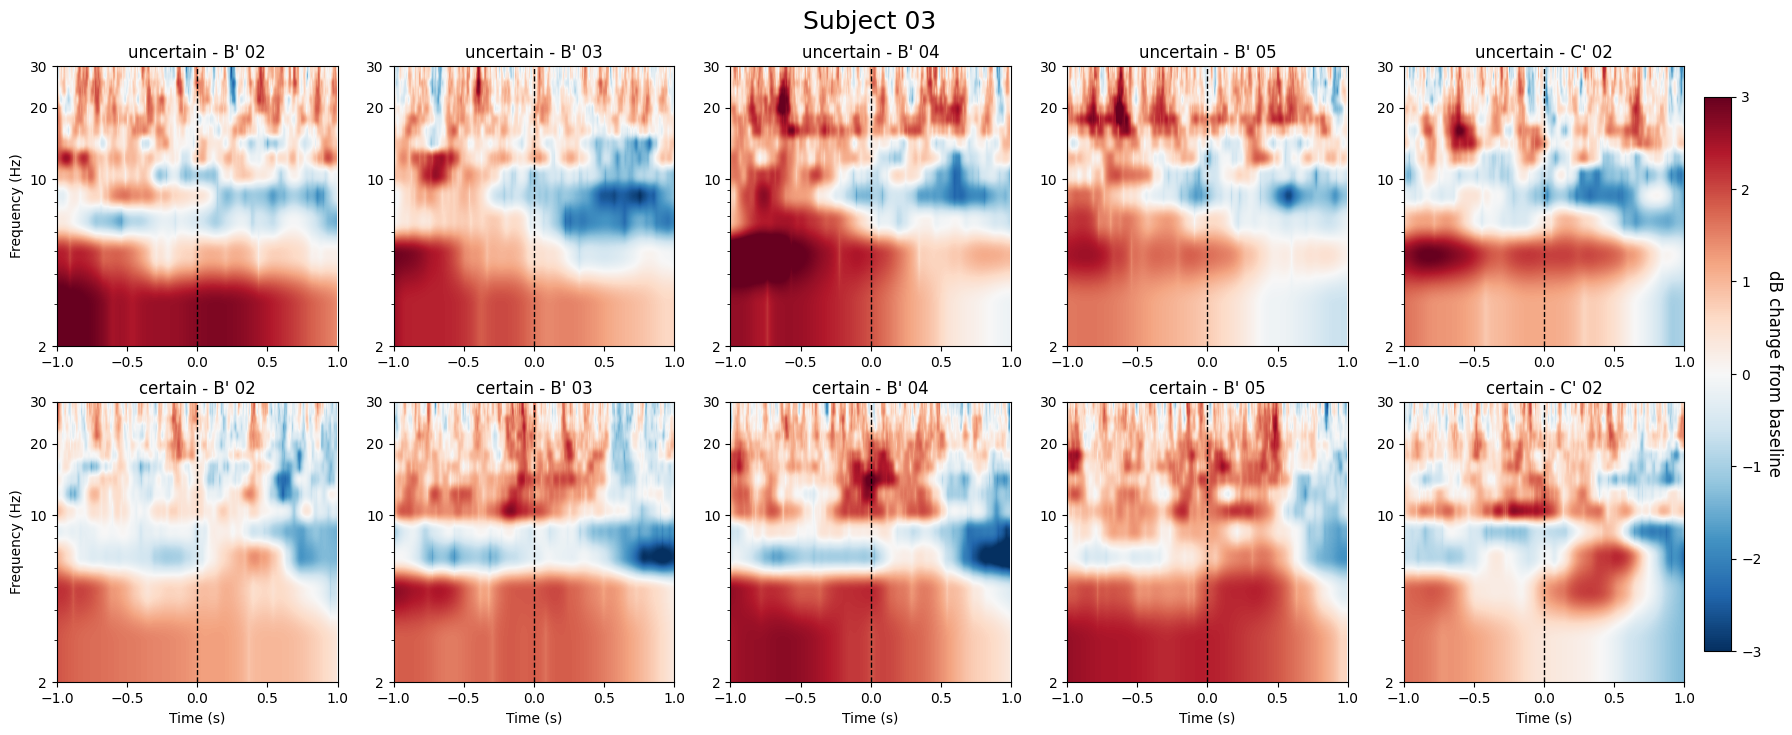

In [2]:
import neuropsy as nps
import neuropsy.analysis as npsa
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from scipy import signal
from scipy.fftpack import next_fast_len
# from scipy.fft import fft, fftfreq, ifft
# import pywt


#********** PARAMETERS **********#
path_data                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path_save                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
subject_ids                 = nps.utils.get_subject_ids_from_path(path_data)

# analysis parameters
conditions                  = ('uncertain', 'certain')
stimulus                    = 'Picture Placed'
tmin                        = -1
tmax                        = 1
baseline                    = (-1, -.5)
baseline_method             = 'mean'

# wavelet parameters
fs                          = 512
t_wl                        = np.arange(-4, 4+1/fs, 1/fs) # long enough time to capture the wavelet for given f and n
frequencies                 = np.arange(2, 32, 2)
cycles                      = np.insert(np.flipud(np.arange(3, 13, 1)), [-1, -2, -3, -4, -5], [3, 4, 5, 6, 7])
n_half_wavelet              = len(t_wl) // 2

# plot parameters
cmap                        = 'RdBu_r'


#********** START ANALYSIS **********#
dict_tfr_power_results = {}
for subject_id in subject_ids:
    start_time_sub = time.time()
    print(f"Starting subject {subject_id}...")
    
    dict_tfr_power_results[subject_id] = {}

    #********** LOAD SUBJECT DATA **********# 
    data = nps.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed')
    
    # subtract total mean from each channel to remove DC bias
    total_mean = np.mean(data.ieeg)
    for i in range(data.ieeg.shape[0]):
        data.ieeg[i, :] = data.ieeg[i, :] - total_mean
        data.ieeg[i, :] = signal.detrend(data.ieeg[i, :])
        
    # select channels in hippocampus
    ch_names = data.df_chan[(data.df_chan['HC left'] == True) | (data.df_chan['HC right'] == True)]['name'].to_list()
    data.select_channels(ch_names=np.ravel(ch_names), inplace=True)


    #********** CREATE MNE RAW IN DATA OBJECT **********#
    data.create_raw()
    

    #********** GET TRIAL TIME POINTS (INDICES) **********#
    # need trial indices for "uncertain" and "certain" conditions from experiment dataframe
    # also need the corresponding trial indices for the baseline (picture shown)
    dict_trial_indices = {
        conditions[0]: [],
        f'{conditions[0]}_baseline': [],
        conditions[1]: [],
        f'{conditions[1]}_baseline': []
    }
    for condition in conditions:
        # get the trial indices for the condition
        idx_condition = data.df_exp[data.df_exp['Trial Category'] == condition][f'Mark for {stimulus}'].to_list()
        idx_baseline = data.df_exp[data.df_exp['Trial Category'] == condition]['Mark for Picture Shown'].to_list()
        # save indices
        dict_trial_indices[condition].append(idx_condition)
        dict_trial_indices[f"{condition}_baseline"].append(idx_baseline)
    # flatten lists
    for key in dict_trial_indices.keys():
        dict_trial_indices[key] = np.ravel(dict_trial_indices[key])


    #********** TIME-FREQUENCY ANALYSIS **********#
    # condition perhaps vary in trial number
    dict_tfr_power_results[subject_id] = {}
    for condition in conditions:
        start_time_cond = time.time()
        print(f"\tStarting condition {repr(condition)}...")
        
        dict_tfr_power_results[subject_id][condition] = {}
        
        for ch in ch_names:
            start_time_ch = time.time()
            
            # use the whole channel signal for computing time-frequency representation
            ch_signal = data.raw._data[ch_names.index(ch), ...]
            
            # ********* FFT of CHANNEL ********* #
            n_conv      = len(t_wl) + len(ch_signal) - 1
            n_conv_fast = next_fast_len(n_conv)
            signal_fft  = np.fft.fft(ch_signal, n_conv_fast)
            
            
            # initialise output data for continuous wavelet transform
            tf_data = np.zeros((len(frequencies), len(ch_signal)))

            # ********* CWT ********* #
            for i, (f, n) in enumerate(zip(frequencies, cycles)):
                
                print(f"creating wavelet with parameters: f = {f}, n = {n}...")
                
                # create wavelet
                wavelet = npsa.morlet(f, n, t_wl)
                
                # fft of wavelet
                # note:
                #   output must match the length of the signal_fft in order to multiply in the frequency domain
                wavelet_fft = np.fft.fft(wavelet, n=n_conv_fast)
                
                # convolution
                coefficients = np.fft.ifft(signal_fft * wavelet_fft, n=n_conv_fast)
                coefficients = coefficients[:n_conv] # remove padding from next_fast_len
                coefficients = coefficients[n_half_wavelet:-n_half_wavelet]
                
                # convert to power in dB
                tf_power = 10 * np.log10(np.abs(coefficients)**2)
                
                # store result for frequency
                tf_data[i, :] = tf_power
            
            # get baseline periods for all trials
            baseline_power = []
            for i in dict_trial_indices[f'{condition}_baseline']:
                # get baseline period for trial
                b_tmin = int(i + int(baseline[0] * fs))
                b_tmax = int(i + int(baseline[1] * fs))
                baseline_power.append(tf_data[:, b_tmin:b_tmax])
                
            # average baseline power
            baseline_power_avg = np.mean(baseline_power, axis=0)
            
            # get power for all trials
            power_trials = []
            for i in dict_trial_indices[condition]:
                # get power for trial
                t_tmin = int(i + int(tmin * fs))
                t_tmax = int(i + int(tmax * fs))
                power_trials.append(tf_data[:, t_tmin:t_tmax])
            
            # baseline correction
            power_trials_corrected = []
            for t_pow in power_trials:
                t_pow_corrected = npsa.apply_baseline(epoch_power=t_pow, baseline_power=baseline_power_avg, method=baseline_method)
                power_trials_corrected.append(t_pow_corrected)
                
            # store result for channel
            result = np.mean(power_trials_corrected, axis=0)
            dict_tfr_power_results[subject_id][condition][ch] = result
            
            # clean up
            # del signal, coefficients, baseline_power, baseline_power_avg, power_trials, power_trials_corrected
            print(f"\t\tChannel {ch} done - {time.time() - start_time_ch:.2f} seconds")
        print(f"\tCondition {repr(condition)} done - {time.time() - start_time_cond:.2f} seconds")
    print(f"Subject {subject_id} done - {time.time() - start_time_sub:.2f} seconds")
    
    #********** PLOT RESULTS **********#
    fig, ax = plt.subplots(nrows=2, ncols=len(ch_names), figsize=(25, 8))
    for i, condition in enumerate(conditions):
        for j, ch in enumerate(ch_names):
            
            im = ax[i, j].imshow(
                dict_tfr_power_results[subject_id][condition][ch], 
                aspect='auto',
                extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
                origin='lower', 
                vmin=-3,
                vmax=3,
                cmap=cmap,
                interpolation='hanning')
            ax[i, j].set_title(f'{condition} - {ch}', fontsize=12)
            ax[i, 0].set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
            ax[1, j].set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
            ax[i, j].axvline(x=0, color='black', linestyle='--', linewidth=1.)
            ax[i, j].set_yscale('log')                              # show frequency in log scale
            ax[i, j].set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
            if i == len(conditions) - 1 and j == len(ch_names) - 1:
                cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.90, pad=0.01, orientation="vertical")
                cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=12)

    fig.suptitle(f"Subject {data._subject_id}", fontsize=18, y=0.95, x=.45)
    
    # print(f"Saving plot for subject {subject_id}...")
    # full_save_path = f"{path_save}/manual/sub{data._subject_id}_power_chan.png"
    # fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
    # print(f"Done - {full_save_path}")
    # plt.close(fig)
    plt.show()
        
    break
        

#********** SAVE RESULTS **********#
# filename = f"{path_save}/data/tfr_power_results_manual.pkl"
# with open(filename, 'wb') as f:
#     print("Saving results...")
#     pickle.dump(dict_tfr_power_results, f)
#     print("Done")

### 1.1 Average Conditions

condition: 'uncertain'
Shape before average:
	(70, 15, 1024)
Shape after average:
	(15, 1024)

condition: 'certain'
Shape before average:
	(70, 15, 1024)
Shape after average:
	(15, 1024)



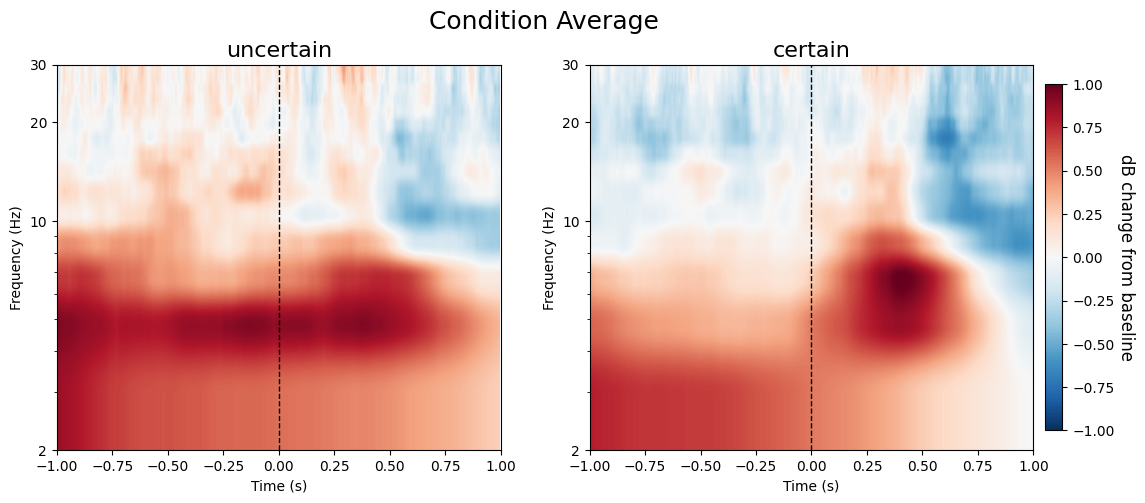

In [83]:
import pickle

path_save   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename    = f"{path_save}/data/tfr_power_results_manual.pkl"
conditions  = ('uncertain', 'certain')

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)
# power_data = dict_tfr_power_results

#********** AVERAGE ALL CHANNELS PER CONDITION **********#
power_averaged = {}
for condition in conditions:
    print(f"condition: {repr(condition)}")
    power_averaged[condition] = []
    
    for subject_id in power_data.keys():
        for channel in power_data[subject_id][condition].keys():
            # save channel data
            power_averaged[condition].append(power_data[subject_id][condition].get(channel))
    
    print("Shape before average:")
    print(f"\t{np.array(power_averaged[condition]).shape}")
    # compute mean of all channels across subjects for condition
    power_averaged[condition] = np.mean(power_averaged[condition], axis=0)
    
    print("Shape after average:")
    print(f"\t{np.array(power_averaged[condition]).shape}\n")
    

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = ax.flatten()
for i, condition in enumerate(conditions):
        
        im = ax[i].imshow(
            power_averaged[condition], 
            aspect='auto',
            extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
            origin='lower', 
            vmin=-1,
            vmax=1,
            cmap=cmap,
            interpolation='hanning')
        ax[i].set_title(f'{condition}', fontsize=16)
        ax[i].set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
        ax[i].set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
        ax[i].axvline(x=0, color='black', linestyle='--', linewidth=1.)
        ax[i].set_yscale('log')                              # show frequency in log scale
        ax[i].set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
        if i == 1:
            cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.90, pad=0.01, orientation="vertical")
            cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=12)

fig.suptitle(f"Condition Average", fontsize=18, y=0.99, x=.45)

full_save_path = f"{path_save}/manual/conditions_power_avg.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

### 1.2 Total Average

condition: 'uncertain'
condition: 'certain'
Shape before average:
	(140, 15, 1024)
Shape after average:
	(15, 1024)



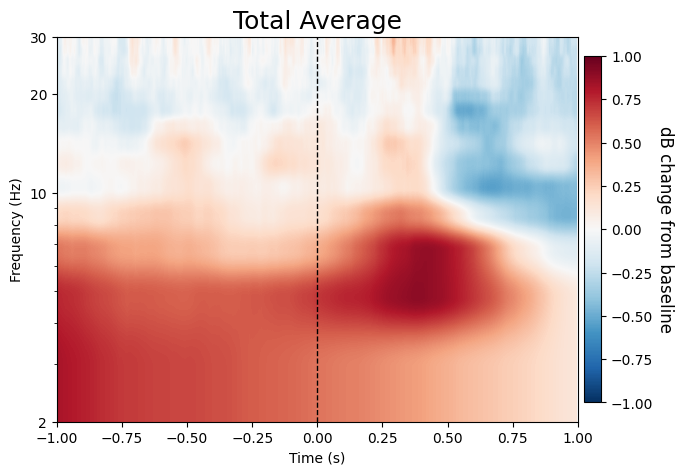

In [84]:
import pickle

path_save   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename    = f"{path_save}/data/tfr_power_results_manual.pkl"
conditions  = ('uncertain', 'certain')

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)

#********** AVERAGE ALL CHANNELS **********#
power_averaged = []
for condition in conditions:
    print(f"condition: {repr(condition)}")
    
    for subject_id in power_data.keys():
        for channel in power_data[subject_id][condition].keys():
            # save channel data
            power_averaged.append(power_data[subject_id][condition].get(channel))
    
print("Shape before average:")
print(f"\t{np.array(power_averaged).shape}")
# compute mean of all channels across subjects
power_averaged = np.mean(power_averaged, axis=0)

print("Shape after average:")
print(f"\t{np.array(power_averaged).shape}\n")
    

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
        
im = ax.imshow(
    power_averaged, 
    aspect='auto',
    extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
    origin='lower', 
    vmin=-1,
    vmax=1,
    cmap=cmap)
ax.set_title('Total Average', fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
if i == 1:
    cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.01, orientation="vertical")
    cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=12)

# fig.suptitle(f"Total Average", fontsize=18, y=0.99, x=.45)

full_save_path = f"{path_save}/manual/total_power_avg.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

### 1.3 Condition Difference

condition: 'uncertain'
Shape before average:
	(70, 15, 1024)
Shape after average:
	(15, 1024)

condition: 'certain'
Shape before average:
	(70, 15, 1024)
Shape after average:
	(15, 1024)



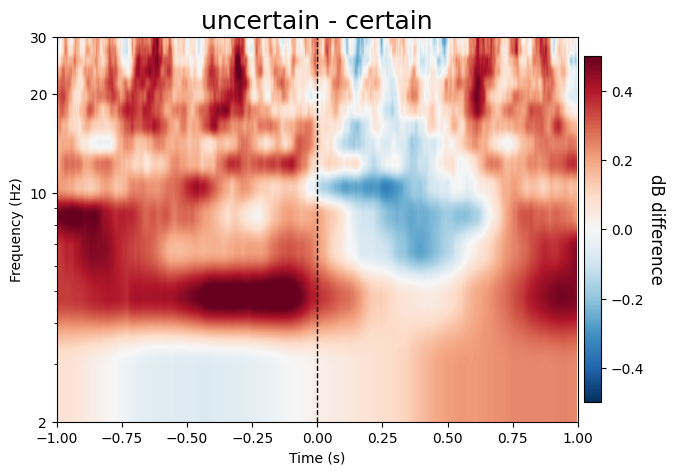

In [85]:
import pickle

path_save   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename    = f"{path_save}/data/tfr_power_results_manual.pkl"
conditions  = ('uncertain', 'certain')

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)

#********** AVERAGE ALL CHANNELS PER CONDITION **********#
power_averaged = {}
for condition in conditions:
    print(f"condition: {repr(condition)}")
    power_averaged[condition] = []
    
    for subject_id in power_data.keys():
        for channel in power_data[subject_id][condition].keys():
            # save channel data
            power_averaged[condition].append(power_data[subject_id][condition].get(channel))
    
    print("Shape before average:")
    print(f"\t{np.array(power_averaged[condition]).shape}")
    # compute mean of all channels across subjects for condition
    power_averaged[condition] = np.mean(power_averaged[condition], axis=0)
    
    print("Shape after average:")
    print(f"\t{np.array(power_averaged[condition]).shape}\n")
    

#********** SUBSTRACT CONDITION AVERAGE TO GET DIFFERENCE **********#
power_diff = power_averaged[conditions[0]] - power_averaged[conditions[1]]
    

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
        
im = ax.imshow(
    power_diff, 
    aspect='auto',
    extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
    origin='lower', 
    vmin=-.5,
    vmax=.5,
    cmap=cmap)
ax.set_title(f"{conditions[0]} - {conditions[1]}", fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
if i == 1:
    cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.01, orientation="vertical")
    cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)

# fig.suptitle(f"Total Average", fontsize=18, y=0.99, x=.45)

full_save_path = f"{path_save}/manual/condition_power_diff.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

# 2. Time-frequency Power Analysis (Manual convolution - 4 conditions)

In [84]:
def check_trials(df, col_name_categories, tmin, tmax, baseline):
    # Check if any trials are too short for the given tmax
    print(f"Checking if any trials are too short for tmax = {tmax} ...")
    idx_too_short = df[df['Reaction Time (computed)'] <= tmax].index.to_list()
    if len(idx_too_short) > 0:
        labels_too_short = df.loc[idx_too_short, col_name_categories].to_list()
        dict_too_short = {}
        for i, label in zip(idx_too_short, labels_too_short):
            if label not in dict_too_short.keys():
                dict_too_short[label] = 1
            else:
                dict_too_short[label] += 1
        for key, value in dict_too_short.items():
            print(f"{value} trials in condition {repr(key)} too short.")
    else:
        print("All trials are longer than tmax.")
        
    # check if any trials are too close to each other
    print(f"Checking if any trials are too close to each other for tmin = {tmin} s and baseline tmin = {np.min(baseline)} s ...")
    idx_too_close = []
    for i, time_placed in enumerate(df['Timestamp (s) for Picture Placed']):
        if i == len(df) - 1:
            break
        time_between = (df['Timestamp (s) for Picture Shown'][i+1] - time_placed)
        if time_between < abs(tmin) + .2: # add 200 ms
            # print(f"{time_between:.2f} s is not enough time between trials {repr(data.df_exp['Trial Identifier'][i+1])} and {repr(data.df_exp['Trial Identifier'][i])} for the chosen tmin ({np.min(baseline)} s), removing trial {repr(data.df_exp['Trial Identifier'][i+1])} with condition {repr(data.df_exp['Condition'][i+1])}.")
            idx_too_close.append(i+1)
        elif time_between < abs(np.min(baseline)) + .2: # add 200 ms
            # print(f"{time_between:.2f} s is not enough time between trials {repr(data.df_exp['Trial Identifier'][i+1])} and {repr(data.df_exp['Trial Identifier'][i])} for the chosen baseline tmin ({np.min(baseline)} s), removing trial {repr(data.df_exp['Trial Identifier'][i+1])} with condition {repr(data.df_exp['Condition'][i+1])}.")
            idx_too_close.append(i+1)
    if len(idx_too_close) > 0:
        labels_too_close = df.loc[idx_too_close, col_name_categories].to_list()
        dict_too_close = {}
        for i, label in zip(idx_too_close, labels_too_close):
            if label not in dict_too_close.keys():
                dict_too_close[label] = 1
            else:
                dict_too_close[label] += 1
        for key, value in dict_too_short.items():
            print(f"{value} trials in condition {repr(key)} too close.")
    else:
        print("All trials are far enough apart.")
            
    return idx_too_short, idx_too_close

In [104]:
import neuropsy as npsy
import neuropsy.analysis as npsya
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from scipy import signal
from scipy.fftpack import next_fast_len
# from scipy.fft import fft, fftfreq, ifft
# import pywt


#********** PARAMETERS **********#
path_data                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path_save                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
subject_ids                 = npsy.utils.get_subject_ids_from_path(path_data)

# analysis parameters
conditions                  = ('not learned', 'correct', 'learned-1', 'learned')
cond_column                 = 'Condition'
stimulus                    = 'Picture Shown'
save_postfix                = 'picshown'
tmin                        = -.2
tmax                        = 1
baseline                    = (-1, -.5)
baseline_method             = 'mean'

# wavelet parameters
fs                          = 512
t_wl                        = np.arange(-4, 4+1/fs, 1/fs) # long enough time to capture the wavelet for given f and n
frequencies                 = np.arange(2, 32, 2)
cycles                      = np.insert(np.flipud(np.arange(3, 13, 1)), [-1, -2, -3, -4, -5], [3, 4, 5, 6, 7])
n_half_wavelet              = len(t_wl) // 2

# plot parameters
cmap                        = 'RdBu_r'


#********** START ANALYSIS **********#
dict_tfr_power_results = {}
for subject_id in subject_ids:
    start_time_sub = time.time()
    print(f"Starting subject {subject_id}...")
    
    dict_tfr_power_results[subject_id] = {}

    #********** LOAD SUBJECT DATA **********# 
    data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed')
    
    # subtract total mean from each channel to remove DC bias
    print("Removing DC bias from iEEG data...")
    total_mean = np.mean(data.ieeg)
    for i in range(data.ieeg.shape[0]):
        data.ieeg[i, :] = data.ieeg[i, :] - total_mean
        data.ieeg[i, :] = signal.detrend(data.ieeg[i, :])
        
    # select channels in hippocampus
    print("Selecting channels in hippocampus...")
    ch_names = data.df_chan[(data.df_chan['HC left'] == True) | (data.df_chan['HC right'] == True)]['name'].to_list()
    data.select_channels(ch_names=np.ravel(ch_names), inplace=True)
    print(f"Selected {len(ch_names)} channels in hippocampus.")

    #********** CHECK TRIAL DURATIONS **********#
    print("Total number of trials for each condition:")
    for c in conditions:
        print(f"\t{c}: {data.df_exp[cond_column].value_counts()[c]}")
    idx_too_short, idx_too_close = check_trials(data.df_exp, cond_column, tmin, tmax, baseline)
    if len(idx_too_short) > 0 or len(idx_too_close) > 0:
        idx_drop = np.unique(np.concatenate((idx_too_short, idx_too_close)))
        data.df_exp = data.df_exp.drop(idx_drop).reset_index(drop=True)
        print("Total number of trials for each condition:")
        for c in conditions:
            print(f"\t{c}: {data.df_exp[cond_column].value_counts()[c]}")

    #********** CREATE MNE RAW IN DATA OBJECT **********#
    data.create_raw()
    

    #********** GET TRIAL TIME POINTS (INDICES) **********#
    # need trial indices for conditions from experiment dataframe
    # also need the corresponding trial indices for the baseline (picture shown)
    dict_trial_indices = {**{f'{c}': [] for c in conditions}, **{f'{c}_baseline': [] for c in conditions}}
    for c in conditions:
        # get the trial indices for the condition
        idx_condition = data.df_exp[data.df_exp[cond_column] == c][f'Mark for {stimulus}'].to_list()
        idx_baseline = data.df_exp[data.df_exp[cond_column] == c]['Mark for Picture Shown'].to_list()
        # save indices
        dict_trial_indices[c].append(idx_condition)
        dict_trial_indices[f"{c}_baseline"].append(idx_baseline)
    # flatten lists
    for key in dict_trial_indices.keys():
        dict_trial_indices[key] = np.ravel(dict_trial_indices[key])


    #********** TIME-FREQUENCY ANALYSIS **********#
    # condition perhaps vary in trial number
    dict_tfr_power_results[subject_id] = {}
    for condition in conditions:
        start_time_cond = time.time()
        print(f"\tStarting condition {repr(condition)}...")
        
        dict_tfr_power_results[subject_id][condition] = {}
        
        for ch in ch_names:
            start_time_ch = time.time()
            
            # use the whole channel signal for computing time-frequency representation
            ch_signal = data.raw._data[ch_names.index(ch), ...]
            
            # ********* FFT of CHANNEL ********* #
            n_conv      = len(t_wl) + len(ch_signal) - 1
            n_conv_fast = next_fast_len(n_conv)
            signal_fft  = np.fft.fft(ch_signal, n_conv_fast)
            
            
            # initialise output data for continuous wavelet transform
            tf_data = np.zeros((len(frequencies), len(ch_signal)))

            # ********* CWT ********* #
            for i, (f, n) in enumerate(zip(frequencies, cycles)):
                
                print(f"creating wavelet with parameters: f = {f}, n = {n}...")
                
                # create wavelet
                wavelet = npsya.morlet(f, n, t_wl)
                
                # fft of wavelet
                # note:
                #   output must match the length of the signal_fft in order to multiply in the frequency domain
                wavelet_fft = np.fft.fft(wavelet, n=n_conv_fast)
                
                # convolution
                coefficients = np.fft.ifft(signal_fft * wavelet_fft, n=n_conv_fast)
                coefficients = coefficients[:n_conv] # remove padding from next_fast_len
                coefficients = coefficients[n_half_wavelet:-n_half_wavelet]
                
                # convert to power in dB
                tf_power = 10 * np.log10(np.abs(coefficients)**2)
                
                # store result for frequency
                tf_data[i, :] = tf_power
            
            # get baseline periods for all trials
            baseline_power = []
            for i in dict_trial_indices[f'{condition}_baseline']:
                # get baseline period for trial
                b_tmin = int(i + int(baseline[0] * fs))
                b_tmax = int(i + int(baseline[1] * fs))
                baseline_power.append(tf_data[:, b_tmin:b_tmax])
                
            # average baseline power
            baseline_power_avg = np.mean(baseline_power, axis=0)
            
            # get power for all trials
            power_trials = []
            for i in dict_trial_indices[condition]:
                # get power for trial
                t_tmin = int(i + int(tmin * fs))
                t_tmax = int(i + int(tmax * fs))
                power_trials.append(tf_data[:, t_tmin:t_tmax])
            
            # baseline correction
            power_trials_corrected = []
            for t_pow in power_trials:
                t_pow_corrected = npsya.apply_baseline(epoch_power=t_pow, baseline_power=baseline_power_avg, method=baseline_method)
                power_trials_corrected.append(t_pow_corrected)
                
            # store result for channel
            result = np.mean(power_trials_corrected, axis=0)
            dict_tfr_power_results[subject_id][condition][ch] = result
            
            # clean up
            # del signal, coefficients, baseline_power, baseline_power_avg, power_trials, power_trials_corrected
            print(f"\t\tChannel {ch} done - {time.time() - start_time_ch:.2f} seconds")
        print(f"\tCondition {repr(condition)} done - {time.time() - start_time_cond:.2f} seconds")
    print(f"Subject {subject_id} done - {time.time() - start_time_sub:.2f} seconds")
    
    #********** PLOT RESULTS **********#
    fig, ax = plt.subplots(nrows=len(conditions), ncols=len(ch_names), figsize=(30, 4*len(conditions)))
    for i, condition in enumerate(conditions):
        for j, ch in enumerate(ch_names):
            
            im = ax[i, j].imshow(
                dict_tfr_power_results[subject_id][condition][ch], 
                aspect='auto',
                extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
                origin='lower', 
                vmin=-3,
                vmax=3,
                cmap=cmap,
                interpolation='hanning')
            ax[i, j].set_title(f'{condition} - {ch}', fontsize=12)
            ax[i, 0].set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
            ax[len(conditions)-1, j].set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
            ax[i, j].axvline(x=0, color='black', linestyle='--', linewidth=1.)
            ax[i, j].set_yscale('log')                              # show frequency in log scale
            ax[i, j].set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
            if i == len(conditions) - 1 and j == len(ch_names) - 1:
                cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.90, pad=0.01, orientation="vertical")
                cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=12)

    fig.suptitle(f"Subject {data._subject_id}", fontsize=18, y=.92, x=.45)

    print(f"Saving plot for subject {data._subject_id}...")
    full_save_path = f"{path_save}/manual-4cond-picshown/sub{data._subject_id}_power_chan.png"
    fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"Done - {full_save_path}")
    plt.close(fig)
    plt.show()
        
    # break
        

#********** SAVE RESULTS **********#
filename = f"{path_save}/data/tfr_power_results_manual_4cond_picshown.pkl"
with open(filename, 'wb') as f:
    print("Saving results as .pkl file...")
    pickle.dump(dict_tfr_power_results, f)
    print("Done")

Starting subject 03...
Removing DC bias from iEEG data...
Selecting channels in hippocampus...
Selected 5 channels in hippocampus.
Total number of trials for each condition:
	not learned: 86
	correct: 16
	learned-1: 50
	learned: 50
Checking if any trials are too short for tmax = 1 ...
1 trials in condition 'learned-1' too short.
1 trials in condition 'learned' too short.
Checking if any trials are too close to each other for tmin = -0.2 s and baseline tmin = -1.0 s ...
All trials are far enough apart.
Total number of trials for each condition:
	not learned: 86
	correct: 16
	learned-1: 49
	learned: 49
Creating RawArray with float64 data, n_channels=5, n_times=823114
    Range : 0 ... 823113 =      0.000 ...  1607.643 secs
Ready.
	Starting condition 'not learned'...
creating wavelet with parameters: f = 2, n = 12...
creating wavelet with parameters: f = 4, n = 11...
creating wavelet with parameters: f = 6, n = 10...
creating wavelet with parameters: f = 8, n = 9...
creating wavelet with 

### 2.1 Average Conditions

In [1]:
import pickle

path_save   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename    = f"{path_save}/data/tfr_power_results_manual_4cond_picshown.pkl"
conditions  = ('not learned', 'correct', 'learned-1', 'learned')

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)

condition: 'not learned'
Shape before average:
	(70, 15, 614)
Shape after average:
	(15, 614)

condition: 'correct'
Shape before average:
	(70, 15, 614)
Shape after average:
	(15, 614)

condition: 'learned-1'
Shape before average:
	(70, 15, 614)
Shape after average:
	(15, 614)

condition: 'learned'
Shape before average:
	(70, 15, 614)
Shape after average:
	(15, 614)



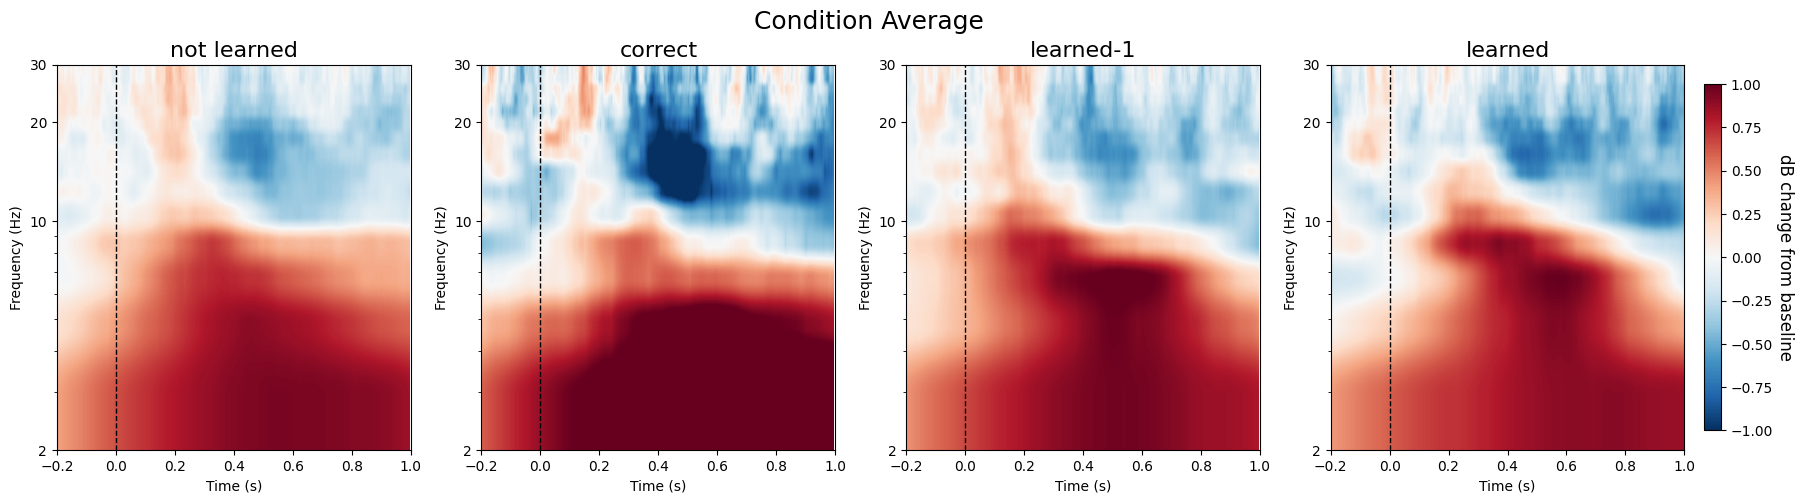

In [108]:
import pickle

path_save   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename    = f"{path_save}/data/tfr_power_results_manual_4cond_picshown.pkl"
conditions  = ('not learned', 'correct', 'learned-1', 'learned')

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)
# power_data = dict_tfr_power_results

#********** AVERAGE ALL CHANNELS PER CONDITION **********#
power_averaged = {}
for condition in conditions:
    print(f"condition: {repr(condition)}")
    power_averaged[condition] = []
    
    for subject_id in power_data.keys():
        for channel in power_data[subject_id][condition].keys():
            # save channel data
            power_averaged[condition].append(power_data[subject_id][condition].get(channel))
    
    print("Shape before average:")
    print(f"\t{np.array(power_averaged[condition]).shape}")
    # compute mean of all channels across subjects for condition
    power_averaged[condition] = np.mean(power_averaged[condition], axis=0)
    
    print("Shape after average:")
    print(f"\t{np.array(power_averaged[condition]).shape}\n")
    

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=len(conditions), figsize=(25, 5))
ax = ax.flatten()
for i, condition in enumerate(conditions):
        
        im = ax[i].imshow(
            power_averaged[condition], 
            aspect='auto',
            extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
            origin='lower', 
            vmin=-1,
            vmax=1,
            cmap=cmap,
            interpolation='hanning')
        ax[i].set_title(f'{condition}', fontsize=16)
        ax[i].set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
        ax[i].set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
        ax[i].axvline(x=0, color='black', linestyle='--', linewidth=1.)
        ax[i].set_yscale('log')                              # show frequency in log scale
        ax[i].set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
        if i == 1:
            cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.90, pad=0.01, orientation="vertical")
            cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=12)

fig.suptitle(f"Condition Average", fontsize=18, y=0.99, x=.45)

full_save_path = f"{path_save}/manual-4cond-picshown/power_cond_avg.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

### 2.2 Total Average

condition: 'not learned'
condition: 'correct'
condition: 'learned-1'
condition: 'learned'
Shape before average:
	(280, 15, 614)
Shape after average:
	(15, 614)



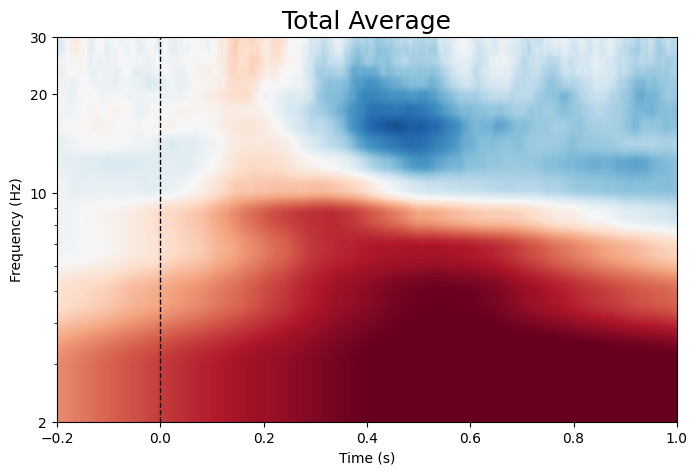

In [111]:
import pickle

path_save   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename    = f"{path_save}/data/tfr_power_results_manual_4cond_picshown.pkl"
conditions  = ('not learned', 'correct', 'learned-1', 'learned')

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)

#********** AVERAGE ALL CHANNELS **********#
power_averaged = []
for condition in conditions:
    print(f"condition: {repr(condition)}")
    
    for subject_id in power_data.keys():
        for channel in power_data[subject_id][condition].keys():
            # save channel data
            power_averaged.append(power_data[subject_id][condition].get(channel))
    
print("Shape before average:")
print(f"\t{np.array(power_averaged).shape}")
# compute mean of all channels across subjects
power_averaged = np.mean(power_averaged, axis=0)

print("Shape after average:")
print(f"\t{np.array(power_averaged).shape}\n")
    

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
        
im = ax.imshow(
    power_averaged, 
    aspect='auto',
    extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
    origin='lower', 
    vmin=-1,
    vmax=1,
    cmap=cmap)
ax.set_title('Total Average', fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
if i == 1:
    cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.01, orientation="vertical")
    cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=12)

# fig.suptitle(f"Total Average", fontsize=18, y=0.99, x=.45)

full_save_path = f"{path_save}/manual-4cond-picshown/total_power_avg.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Condition Difference

condition: 'not learned'
Shape before average:
	(70, 15, 614)
Shape after average:
	(15, 614)

condition: 'learned'
Shape before average:
	(70, 15, 614)
Shape after average:
	(15, 614)



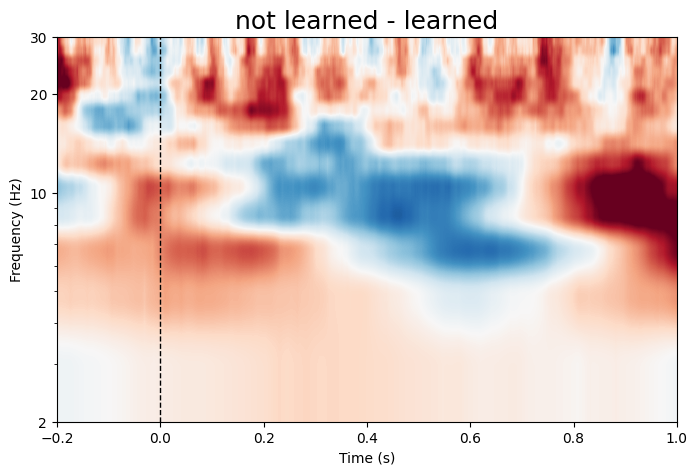

In [115]:
import pickle

path_save   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename    = f"{path_save}/data/tfr_power_results_manual_4cond_picshown.pkl"
conditions  = ('not learned', 'correct', 'learned-1', 'learned')

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)

#********** AVERAGE ALL CHANNELS PER CONDITION **********#
power_averaged = {}
for condition in [conditions[0], conditions[-1]]:
    print(f"condition: {repr(condition)}")
    power_averaged[condition] = []
    
    for subject_id in power_data.keys():
        for channel in power_data[subject_id][condition].keys():
            # save channel data
            power_averaged[condition].append(power_data[subject_id][condition].get(channel))
    
    print("Shape before average:")
    print(f"\t{np.array(power_averaged[condition]).shape}")
    # compute mean of all channels across subjects for condition
    power_averaged[condition] = np.mean(power_averaged[condition], axis=0)
    
    print("Shape after average:")
    print(f"\t{np.array(power_averaged[condition]).shape}\n")
    

#********** SUBSTRACT CONDITION AVERAGE TO GET DIFFERENCE **********#
power_diff = power_averaged[conditions[0]] - power_averaged[conditions[-1]]
    

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
        
im = ax.imshow(
    power_diff, 
    aspect='auto',
    extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
    origin='lower', 
    vmin=-.5,
    vmax=.5,
    cmap=cmap)
ax.set_title(f"{conditions[0]} - {conditions[-1]}", fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
if i == 1:
    cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.01, orientation="vertical")
    cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)

# fig.suptitle(f"Total Average", fontsize=18, y=0.99, x=.45)

full_save_path = f"{path_save}/manual-4cond-picshown/condition_power_diff.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

## 2. Time-frequency Representation (Using PyWavelets Library)

In [36]:
import neuropsy as nps
import neuropsy.analysis as npsa
import numpy as np
import pywt
import matplotlib.pyplot as plt
import time
import pickle

#********** PARAMETERS **********#
path_data                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path_save                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
subject_ids                 = nps.utils.get_subject_ids_from_path(path_data)

# analysis parameters
conditions                  = ('uncertain', 'certain')
stimulus                    = 'Picture Placed'
tmin                        = -1
tmax                        = 1
baseline                    = (-1, -.5)
baseline_method             = 'mean'

# wavelet parameters
fs                          = 512
dt                          = 1/fs
freqs                       = np.arange(2, 32, 2)
bandwidth                   = 1.5
center_frequency            = 2.0
wavelet                     = pywt.ContinuousWavelet(f'cmor{bandwidth}-{center_frequency}') # complex morlet
# wavelet                 = f'cmor{bandwidth}-{center_frequency}' # complex morlet
scales                      = npsa.get_scales(freqs=freqs, wavelet=wavelet, fs=fs)

# plot parameters
cmap                        = 'RdBu_r'


#********** START ANALYSIS **********#
dict_tfr_power_results = {}
for subject_id in subject_ids:
    start_time_sub = time.time()
    print(f"Starting subject {subject_id}...")
    
    dict_tfr_power_results[subject_id] = {}

    #********** LOAD SUBJECT DATA **********# 
    data = nps.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed')

    # select channels in hippocampus
    ch_names = data.df_chan[(data.df_chan['HC left'] == True) | (data.df_chan['HC right'] == True)]['name'].to_list()
    data.select_channels(ch_names=np.ravel(ch_names), inplace=True)


    #********** CREATE MNE RAW IN DATA OBJECT **********#
    data.create_raw()
    

    #********** GET TRIAL TIME POINTS (INDICES) **********#
    # need trial indices for "uncertain" and "certain" conditions from experiment dataframe
    # also need the corresponding trial indices for the baseline (picture shown)
    dict_trial_indices = {
        conditions[0]: [],
        f'{conditions[0]}_baseline': [],
        conditions[1]: [],
        f'{conditions[1]}_baseline': []
    }
    for condition in conditions:
        # get the trial indices for the condition
        idx_condition = data.df_exp[data.df_exp['Trial Category'] == condition][f'Mark for {stimulus}'].to_list()
        idx_baseline = data.df_exp[data.df_exp['Trial Category'] == condition]['Mark for Picture Shown'].to_list()
        # save indices
        dict_trial_indices[condition].append(idx_condition)
        dict_trial_indices[f"{condition}_baseline"].append(idx_baseline)
    # flatten lists
    for key in dict_trial_indices.keys():
        dict_trial_indices[key] = np.ravel(dict_trial_indices[key])


    #********** TIME-FREQUENCY ANALYSIS **********#
    # condition perhaps vary in trial number
    dict_tfr_power_results[subject_id] = {}
    for condition in conditions:
        start_time_cond = time.time()
        print(f"\tStarting condition {repr(condition)}...")
        
        dict_tfr_power_results[subject_id][condition] = {}
        
        for ch in ch_names:
            start_time_ch = time.time()
            
            # use the whole channel signal for computing time-frequency representation
            signal = data.raw._data[ch_names.index(ch), ...]
            
            # compute time-frequency representation
            [coefficients, frequencies]     = pywt.cwt(data=signal, scales=scales, wavelet=wavelet, sampling_period=dt)
            # extract amplitude (magnitude of complex number is amplitude)
            amplitude                       = np.abs(coefficients)
            # convert to power (the amplitude squared gives the power)
            power_all                       = amplitude ** 2
            # scale power to log10
            power_all                       = 10 * np.log10(power_all)
            
            # get baseline periods for all trials
            baseline_power = []
            for i in dict_trial_indices[f'{condition}_baseline']:
                # get baseline period for trial
                b_tmin = int(i + int(baseline[0] * fs))
                b_tmax = int(i + int(baseline[1] * fs))
                baseline_power.append(power_all[:, b_tmin:b_tmax])
                
            # average baseline power
            baseline_power_avg = np.mean(baseline_power, axis=0)
            
            # get power for all trials
            power_trials = []
            for i in dict_trial_indices[condition]:
                # get power for trial
                t_tmin = int(i + int(tmin * fs))
                t_tmax = int(i + int(tmax * fs))
                power_trials.append(power_all[:, t_tmin:t_tmax])
                
            # baseline correction
            power_trials_corrected = []
            for t_pow in power_trials:
                t_pow_corrected = npsa.apply_baseline(epoch_power=t_pow, baseline_power=baseline_power_avg, method=baseline_method)
                power_trials_corrected.append(t_pow_corrected)
            
            # average across trials and save result for channel
            dict_tfr_power_results[subject_id][condition][ch] = np.mean(power_trials_corrected, axis=0, dtype=np.float64)
            
            # clean up
            # del signal, coefficients, amplitude, power_all, baseline_power, baseline_power_avg, power_trials, power_trials_corrected
            print(f"\t\tChannel {ch} done - {time.time() - start_time_ch:.2f} seconds")
        print(f"\tCondition {repr(condition)} done - {time.time() - start_time_cond:.2f} seconds")
    print(f"Subject {subject_id} done - {time.time() - start_time_sub:.2f} seconds")
    
    #********** PLOT RESULTS **********#
    fig, ax = plt.subplots(nrows=2, ncols=len(ch_names), figsize=(25, 8))
    for i, condition in enumerate(conditions):
        for j, ch in enumerate(ch_names):
            
            im = ax[i, j].imshow(
                dict_tfr_power_results[subject_id][condition][ch], 
                aspect='auto',
                extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
                origin='lower', 
                vmin=-3,
                vmax=3,
                cmap=cmap,
                interpolation='hanning')
            ax[i, j].set_title(f'{condition} - {ch}', fontsize=12)
            ax[i, 0].set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
            ax[1, j].set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
            ax[i, j].axvline(x=0, color='black', linestyle='--', linewidth=1.)
            ax[i, j].set_yscale('log')                              # show frequency in log scale
            ax[i, j].set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
            if i == len(conditions) - 1 and j == len(ch_names) - 1:
                cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.90, pad=0.01, orientation="vertical")
                cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=12)

    fig.suptitle(f"Subject {data._subject_id}", fontsize=18, y=0.95, x=.45)
    
    print(f"Saving plot for subject {subject_id}...")
    full_save_path = f"{path_save}/pywt/sub{data._subject_id}_power_chan.png"
    fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"Done - {full_save_path}")
    plt.close(fig)
    
    # break

#********** SAVE RESULTS **********#
filename = f"{path_save}/data/tfr_power_results_pywt.pkl"
with open(filename, 'wb') as f:
    print("Saving results...")
    pickle.dump(dict_tfr_power_results, f)
    print("Done")

Starting subject 03...
Creating RawArray with float64 data, n_channels=5, n_times=823114
    Range : 0 ... 823113 =      0.000 ...  1607.643 secs
Ready.
	Starting condition 'uncertain'...
		Channel B' 02 done - 12.59 seconds
		Channel B' 03 done - 12.46 seconds
		Channel B' 04 done - 12.57 seconds
		Channel B' 05 done - 12.35 seconds
		Channel C' 02 done - 12.43 seconds
	Condition 'uncertain' done - 62.40 seconds
	Starting condition 'certain'...
		Channel B' 02 done - 12.51 seconds
		Channel B' 03 done - 12.51 seconds
		Channel B' 04 done - 12.47 seconds
		Channel B' 05 done - 12.48 seconds
		Channel C' 02 done - 12.80 seconds
	Condition 'certain' done - 62.76 seconds
Subject 03 done - 133.28 seconds
Saving plot for subject 03...
Done - /mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis/pywt/sub03_power_chan.png
Starting subject 04...
Creating RawArray with float64 data, n_channels=8, n_times=868110
    Range

### 2.1 Average Conditions

condition: 'uncertain'
Shape before average:
	(70, 15, 1024)
Shape after average:
	(15, 1024)

condition: 'certain'
Shape before average:
	(70, 15, 1024)
Shape after average:
	(15, 1024)



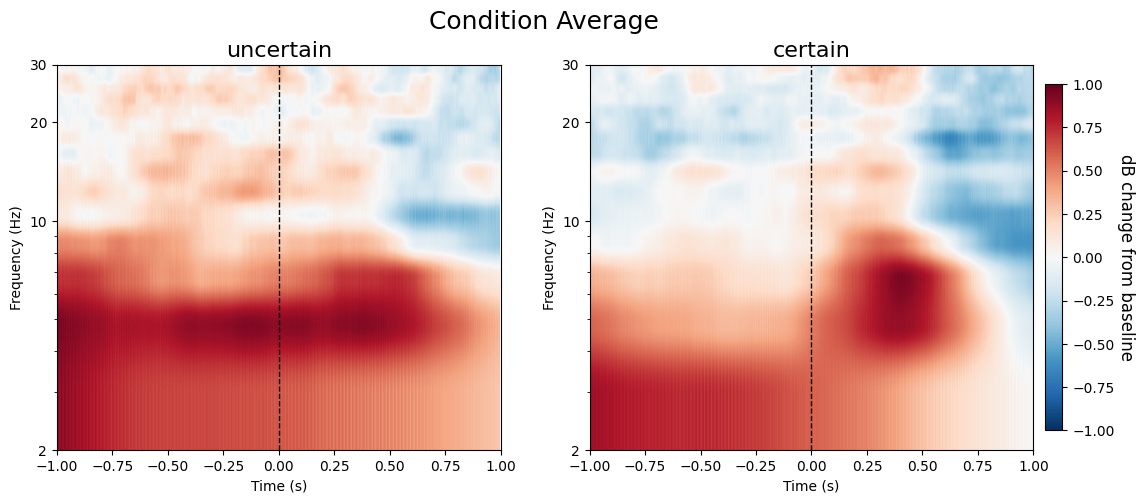

In [38]:
import pickle

path_save   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename    = f"{path_save}/data/tfr_power_results_pywt.pkl"
conditions  = ('uncertain', 'certain')

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)
# power_data = dict_tfr_power_results

#********** AVERAGE ALL CHANNELS PER CONDITION **********#
power_averaged = {}
for condition in conditions:
    print(f"condition: {repr(condition)}")
    power_averaged[condition] = []
    
    for subject_id in power_data.keys():
        for channel in power_data[subject_id][condition].keys():
            # save channel data
            power_averaged[condition].append(power_data[subject_id][condition].get(channel))
    
    print("Shape before average:")
    print(f"\t{np.array(power_averaged[condition]).shape}")
    # compute mean of all channels across subjects for condition
    power_averaged[condition] = np.mean(power_averaged[condition], axis=0)
    
    print("Shape after average:")
    print(f"\t{np.array(power_averaged[condition]).shape}\n")
    

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = ax.flatten()
for i, condition in enumerate(conditions):
        
        im = ax[i].imshow(
            power_averaged[condition], 
            aspect='auto',
            extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
            origin='lower', 
            vmin=-1,
            vmax=1,
            cmap=cmap,
            interpolation='hanning')
        ax[i].set_title(f'{condition}', fontsize=16)
        ax[i].set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
        ax[i].set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
        ax[i].axvline(x=0, color='black', linestyle='--', linewidth=1.)
        ax[i].set_yscale('log')                              # show frequency in log scale
        ax[i].set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
        if i == 1:
            cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.90, pad=0.01, orientation="vertical")
            cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=12)

fig.suptitle(f"Condition Average", fontsize=18, y=0.99, x=.45)

full_save_path = f"{path_save}/pywt/conditions_power_avg.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

### 2.2 Total Average

condition: 'uncertain'
condition: 'certain'
Shape before average:
	(140, 15, 1024)
Shape after average:
	(15, 1024)



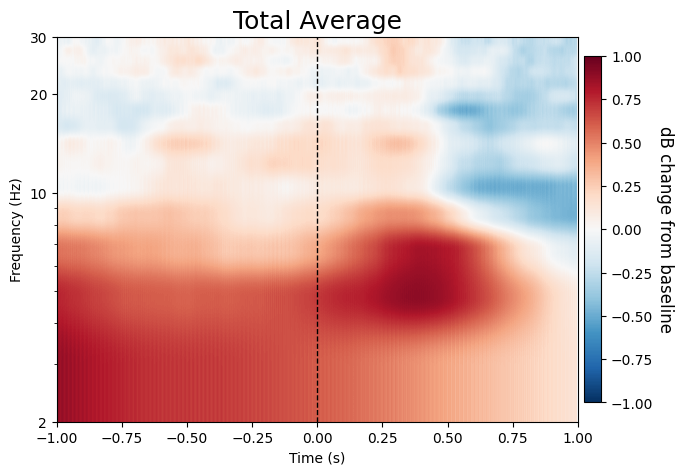

In [46]:
import pickle

path_save   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename    = f"{path_save}/data/tfr_power_results_pywt.pkl"
conditions  = ('uncertain', 'certain')

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)

#********** AVERAGE ALL CHANNELS **********#
power_averaged = []
for condition in conditions:
    print(f"condition: {repr(condition)}")
    
    for subject_id in power_data.keys():
        for channel in power_data[subject_id][condition].keys():
            # save channel data
            power_averaged.append(power_data[subject_id][condition].get(channel))
    
print("Shape before average:")
print(f"\t{np.array(power_averaged).shape}")
# compute mean of all channels across subjects
power_averaged = np.mean(power_averaged, axis=0)

print("Shape after average:")
print(f"\t{np.array(power_averaged).shape}\n")
    

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
        
im = ax.imshow(
    power_averaged, 
    aspect='auto',
    extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
    origin='lower', 
    vmin=-1,
    vmax=1,
    cmap=cmap)
ax.set_title('Total Average', fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
if i == 1:
    cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.01, orientation="vertical")
    cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=12)

# fig.suptitle(f"Total Average", fontsize=18, y=0.99, x=.45)

full_save_path = f"{path_save}/pywt/total_power_avg.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Condition Difference

condition: 'uncertain'
Shape before average:
	(70, 15, 1024)
Shape after average:
	(15, 1024)

condition: 'certain'
Shape before average:
	(70, 15, 1024)
Shape after average:
	(15, 1024)



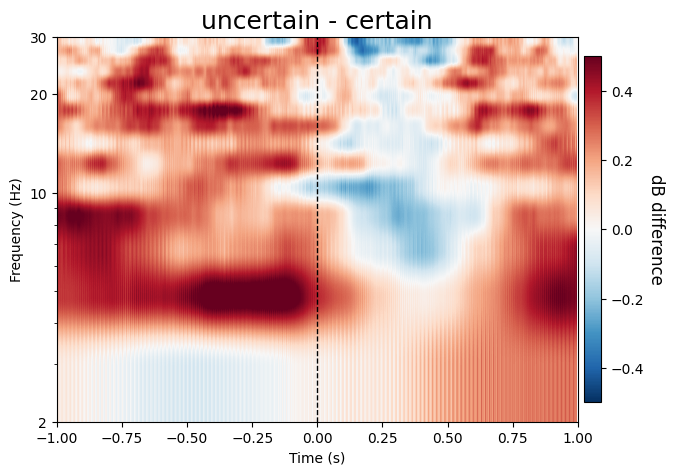

In [51]:
import pickle

path_save   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename    = f"{path_save}/data/tfr_power_results_pywt.pkl"
conditions  = ('uncertain', 'certain')

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    power_data = pickle.load(f)

#********** AVERAGE ALL CHANNELS PER CONDITION **********#
power_averaged = {}
for condition in conditions:
    print(f"condition: {repr(condition)}")
    power_averaged[condition] = []
    
    for subject_id in power_data.keys():
        for channel in power_data[subject_id][condition].keys():
            # save channel data
            power_averaged[condition].append(power_data[subject_id][condition].get(channel))
    
    print("Shape before average:")
    print(f"\t{np.array(power_averaged[condition]).shape}")
    # compute mean of all channels across subjects for condition
    power_averaged[condition] = np.mean(power_averaged[condition], axis=0)
    
    print("Shape after average:")
    print(f"\t{np.array(power_averaged[condition]).shape}\n")
    

#********** SUBSTRACT CONDITION AVERAGE TO GET DIFFERENCE **********#
power_diff = power_averaged[conditions[0]] - power_averaged[conditions[1]]
    

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
        
im = ax.imshow(
    power_diff, 
    aspect='auto',
    extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
    origin='lower', 
    vmin=-.5,
    vmax=.5,
    cmap=cmap)
ax.set_title(f"{conditions[0]} - {conditions[1]}", fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
if i == 1:
    cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.01, orientation="vertical")
    cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)

# fig.suptitle(f"Total Average", fontsize=18, y=0.99, x=.45)

full_save_path = f"{path_save}/pywt/condition_power_diff.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

### (optional) Display Time-frequency Results for One Frequency

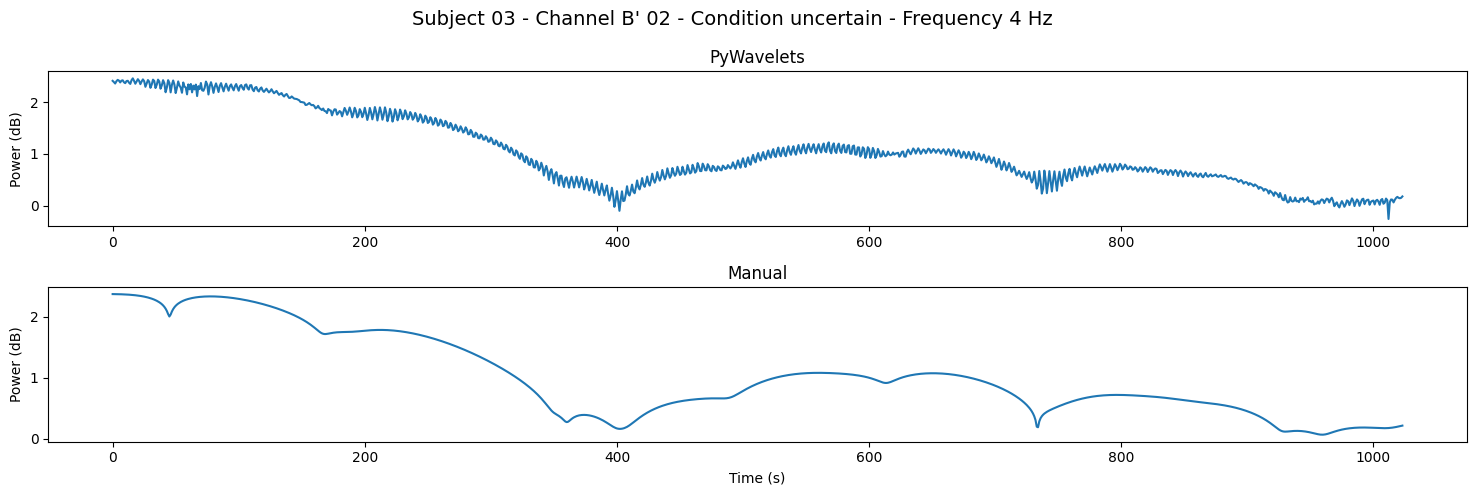

In [ ]:
import pickle

path_save       = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename_pywt   = f"{path_save}/data/tfr_power_results_pywt.pkl"
filename_man    = f"{path_save}/data/tfr_power_results_manual.pkl"
frequencies     = np.arange(2, 32, 2)

# load previously computed time-frequency power for all subjects
with open(filename_pywt, 'rb') as f:
    power_pywt = pickle.load(f)
with open(filename_man, 'rb') as f:
    power_man = pickle.load(f)


subject_id  = '03'
condition   = 'uncertain'
channel     = 'B\' 02'
frequency   = 1

plot_pywt   = power_pywt[str(subject_id)][condition][channel][frequency]
plot_man    = power_man[str(subject_id)][condition][channel][frequency]

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15, 5))
ax = ax.flatten()

ax[0].plot(plot_pywt)
ax[0].set_title('PyWavelets')
ax[0].set_ylabel('Power (dB)')

ax[1].plot(plot_man)
ax[1].set_title('Manual')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Power (dB)')

fig.suptitle(f"Subject {subject_id} - Channel {channel} - Condition {condition} - Frequency {frequencies[frequency]} Hz", fontsize=14, y=.98)
plt.tight_layout()
plt.show()

# Time-frequency Power Analysis (Manual convolution - 4 conditions - bins - baseline correct within trials)

In [2]:
import neuropsy as npsy

path = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'

data = npsy.DataHandler(path=path, subject_id='03', exp_phase=2, fs=512, verbose=True)
data.load(load_saved=True, postfix='preprocessed')

initializing data...
path:			'/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
subject ID:		03
experiment phase:	2 (learning)
sampling frequency:	512 Hz
done
loading data...
no path provided. Using path '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed' from initialization
loading iEEG data...
loading saved data file 'sub03_ieeg_preprocessed.pkl'
use <DataHandler>.ieeg to access intracranial EEG data
done
loading picture target data...
loading saved targets data from '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed/sub03_targets_preprocessed.csv'
use <DataHandler>.df_targets to access targets dataframe
done
loading experiment metadata...
loading saved experiment data file '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed/sub03_exp_preprocessed.csv'
use <DataHandler>.df_exp to access experiment dataframe
done
loading channel me

In [12]:
print(len(data.df_exp))
print(len(data.df_exp[data.df_exp['outlier'] == True]))
data.df_exp = data.df_exp[data.df_exp['outlier'] == False]
print(len(data.df_exp))

197
0
197


In [14]:
conditions                  = ('not learned', 'correct', 'learned-1', 'learned')

{**{f'{c}_onset': [] for c in conditions}, **{f'{c}_offset': [] for c in conditions}, **{f'{c}_baseline': [] for c in conditions}}

{'not learned_onset': [],
 'correct_onset': [],
 'learned-1_onset': [],
 'learned_onset': [],
 'not learned_offset': [],
 'correct_offset': [],
 'learned-1_offset': [],
 'learned_offset': [],
 'not learned_baseline': [],
 'correct_baseline': [],
 'learned-1_baseline': [],
 'learned_baseline': []}

In [33]:
def bin_data(data, nbins):
    """bin_data Bin data into N bins.

    Args:
        data (ndarray): Data to bin.
        nbins (int): Number of bins to create.

    Returns:
        data_bins: Binned data.
    """
    ndim = data.ndim
    
    if ndim == 1:
        bin_size = len(data) / nbins
    elif ndim == 2: # use second dimension (time axis)
        bin_size = data.shape[1] / nbins
    else:
        raise ValueError("Data must be 1D or 2D.")
    
    step = 

test = np.arange(320)
nbins = 100

print(test.shape)
out = bin_data(test, nbins)
np.asarray(out).shape

(320,)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

In [58]:
import numpy as np
test = np.arange(15 * 364).reshape(15, 364)
nbins = 100

power_bins = np.array_split(test, nbins, axis=1)

power_bins_avg = np.zeros((15, nbins))
for i, power_bin in enumerate(power_bins):
    power_bins_avg[:, i] = np.mean(power_bin, axis=1)

# for i, l in enumerate(np.array_split(test, nbins, axis=1)):
#     print(f"sublist {i} has shape {l.shape}")
#     print(f"sublist {i} averaged shape {np.mean(l, axis=1).shape}")

In [63]:
np.concatenate([test, power_bins_avg], axis=1)

array([[0.000e+00, 1.000e+00, 2.000e+00, ..., 3.560e+02, 3.590e+02,
        3.620e+02],
       [3.640e+02, 3.650e+02, 3.660e+02, ..., 7.200e+02, 7.230e+02,
        7.260e+02],
       [7.280e+02, 7.290e+02, 7.300e+02, ..., 1.084e+03, 1.087e+03,
        1.090e+03],
       ...,
       [4.368e+03, 4.369e+03, 4.370e+03, ..., 4.724e+03, 4.727e+03,
        4.730e+03],
       [4.732e+03, 4.733e+03, 4.734e+03, ..., 5.088e+03, 5.091e+03,
        5.094e+03],
       [5.096e+03, 5.097e+03, 5.098e+03, ..., 5.452e+03, 5.455e+03,
        5.458e+03]])

Starting subject 03...
Removing DC bias from iEEG data...
Selecting channels in hippocampus...
Selected 5 channels in hippocampus.
Removing outliers from experiment dataframe...
Removed 5 outliers from experiment dataframe.
Creating RawArray with float64 data, n_channels=5, n_times=823114
    Range : 0 ... 823113 =      0.000 ...  1607.643 secs
Ready.
	Starting condition 'not learned'...
creating wavelet with parameters: f = 2, n = 12...
creating wavelet with parameters: f = 4, n = 11...
creating wavelet with parameters: f = 6, n = 10...
creating wavelet with parameters: f = 8, n = 9...
creating wavelet with parameters: f = 10, n = 8...
creating wavelet with parameters: f = 12, n = 7...
creating wavelet with parameters: f = 14, n = 7...
creating wavelet with parameters: f = 16, n = 6...
creating wavelet with parameters: f = 18, n = 6...
creating wavelet with parameters: f = 20, n = 5...
creating wavelet with parameters: f = 22, n = 5...
creating wavelet with parameters: f = 24, n = 4..

NameError: name 'full_save_path' is not defined

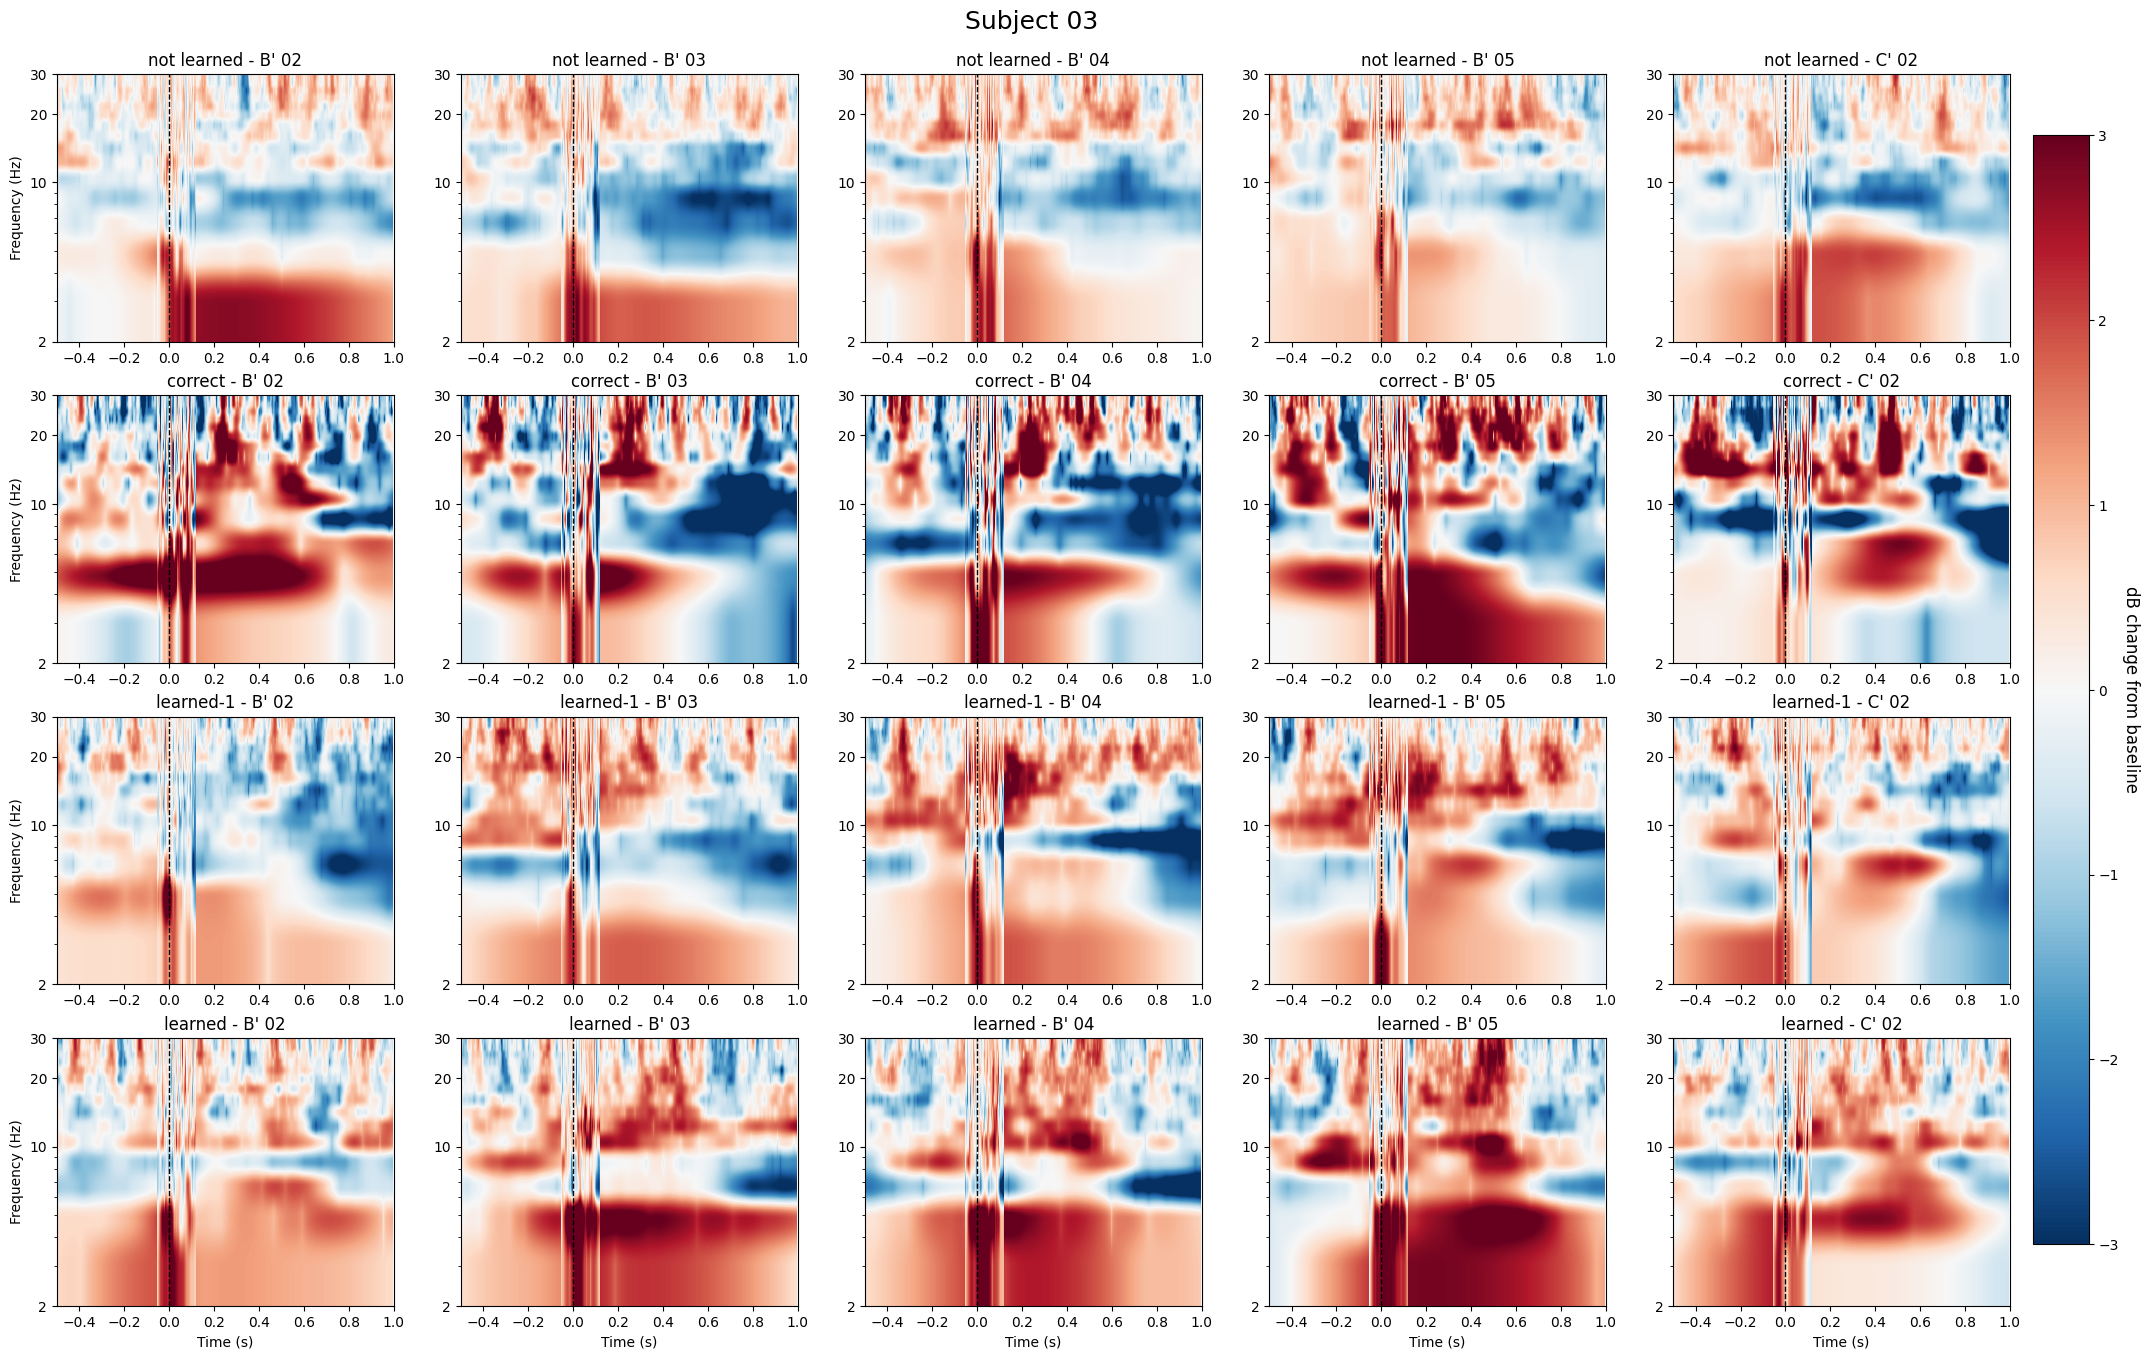

In [80]:
import neuropsy as npsy
import neuropsy.analysis as npsya
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from scipy import signal
from scipy.fftpack import next_fast_len


#********** PARAMETERS **********#
path_data                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path_save                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
subject_ids                 = npsy.utils.get_subject_ids_from_path(path_data)

# analysis parameters
conditions                  = ('not learned', 'correct', 'learned-1', 'learned')
cond_column                 = 'Condition'
stimulus_onset              = 'Picture Shown'
stimulus_offset             = 'Picture Placed'
nbins_between               = 100
save_postfix                = 'picshownandplaced'
tmin                        = -.5
tmax                        = 1
baseline                    = (-1, -.5)
baseline_method             = 'mean'

# wavelet parameters
fs                          = 512
t_wl                        = np.arange(-4, 4+1/fs, 1/fs) # long enough time to capture the wavelet for given f and n
frequencies                 = np.arange(2, 32, 2)
cycles                      = np.insert(np.flipud(np.arange(3, 13, 1)), [-1, -2, -3, -4, -5], [3, 4, 5, 6, 7])
n_half_wavelet              = len(t_wl) // 2

# plot parameters
cmap                        = 'RdBu_r'


#********** START ANALYSIS **********#
dict_tfr_power_results = {}
for subject_id in subject_ids:
    start_time_sub = time.time()
    print(f"Starting subject {subject_id}...")
    
    dict_tfr_power_results[subject_id] = {}

    #********** LOAD SUBJECT DATA **********# 
    data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed')
    
    # subtract total mean from each channel to remove DC bias
    print("Removing DC bias from iEEG data...")
    total_mean = np.mean(data.ieeg)
    for i in range(data.ieeg.shape[0]):
        data.ieeg[i, :] = data.ieeg[i, :] - total_mean
        data.ieeg[i, :] = signal.detrend(data.ieeg[i, :])
        
    # select channels in hippocampus
    print("Selecting channels in hippocampus...")
    ch_names = data.df_chan[(data.df_chan['HC left'] == True) | (data.df_chan['HC right'] == True)]['name'].to_list()
    data.select_channels(ch_names=np.ravel(ch_names), inplace=True)
    print(f"Selected {len(ch_names)} channels in hippocampus.")
    
    # remove outliers
    print("Removing outliers from experiment dataframe...")
    len_before = len(data.df_exp)
    data.df_exp = data.df_exp[data.df_exp['outlier'] == False]
    print(f"Removed {len_before - len(data.df_exp)} outliers from experiment dataframe.")

    # [INFO] not needed when using Picture Shown and Picture Placed and bins in between
    # #********** CHECK TRIAL DURATIONS **********# 
    # print("Total number of trials for each condition:")
    # for c in conditions:
    #     print(f"\t{c}: {data.df_exp[cond_column].value_counts()[c]}")
    # idx_too_short, idx_too_close = check_trials(data.df_exp, cond_column, tmin, tmax, baseline)
    # if len(idx_too_short) > 0 or len(idx_too_close) > 0:
    #     idx_drop = np.unique(np.concatenate((idx_too_short, idx_too_close)))
    #     data.df_exp = data.df_exp.drop(idx_drop).reset_index(drop=True)
    #     print("Total number of trials for each condition:")
    #     for c in conditions:
    #         print(f"\t{c}: {data.df_exp[cond_column].value_counts()[c]}")

    #********** CREATE MNE RAW IN DATA OBJECT **********#
    data.create_raw()
    

    #********** GET TRIAL TIME POINTS (INDICES) **********#
    # need trial indices for conditions from experiment dataframe
    # also need the corresponding trial indices for the baseline (picture shown)
    dict_trial_indices = {**{f'{c}_onset': [] for c in conditions}, **{f'{c}_offset': [] for c in conditions}, **{f'{c}_baseline': [] for c in conditions}}
    for c in conditions:
        # get the trial indices for the condition
        idx_onset       = data.df_exp[data.df_exp[cond_column] == c][f'Mark for {stimulus_onset}'].to_list()
        idx_offset      = data.df_exp[data.df_exp[cond_column] == c][f'Mark for {stimulus_offset}'].to_list()
        idx_baseline    = data.df_exp[data.df_exp[cond_column] == c]['Mark for Picture Shown'].to_list()
        # save indices
        dict_trial_indices[f"{c}_onset"].append(idx_onset)
        dict_trial_indices[f"{c}_offset"].append(idx_offset)
        dict_trial_indices[f"{c}_baseline"].append(idx_baseline)
    # flatten
    for key in dict_trial_indices.keys():
        dict_trial_indices[key] = np.ravel(dict_trial_indices[key])


    #********** TIME-FREQUENCY ANALYSIS **********#
    # condition perhaps vary in trial number
    dict_tfr_power_results[subject_id] = {}
    for condition in conditions:
        start_time_cond = time.time()
        print(f"\tStarting condition {repr(condition)}...")
        
        dict_tfr_power_results[subject_id][condition] = {}
        
        for ch in ch_names:
            start_time_ch = time.time()
            
            # use the whole channel signal for computing time-frequency representation
            ch_signal = data.raw._data[ch_names.index(ch), ...]
            
            # ********* FFT of CHANNEL ********* #
            n_conv      = len(t_wl) + len(ch_signal) - 1
            n_conv_fast = next_fast_len(n_conv)
            signal_fft  = np.fft.fft(ch_signal, n_conv_fast)
            
            
            # initialise output data for continuous wavelet transform
            tf_data = np.zeros((len(frequencies), len(ch_signal)))

            # ********* CWT ********* #
            for i, (f, n) in enumerate(zip(frequencies, cycles)):
                
                print(f"creating wavelet with parameters: f = {f}, n = {n}...")
                
                # create wavelet
                wavelet = npsya.morlet(f, n, t_wl)
                
                # fft of wavelet
                # note:
                #   output must match the length of the signal_fft in order to multiply in the frequency domain
                wavelet_fft = np.fft.fft(wavelet, n=n_conv_fast)
                
                # convolution
                coefficients = np.fft.ifft(signal_fft * wavelet_fft, n=n_conv_fast)
                coefficients = coefficients[:n_conv] # remove padding from next_fast_len
                coefficients = coefficients[n_half_wavelet:-n_half_wavelet]
                
                # convert to power in dB
                tf_power = 10 * np.log10(np.abs(coefficients)**2)
                
                # store result for frequency
                tf_data[i, :] = tf_power
            
            # ********* POSTPROCESSING ********* #
            # Note:
            #   - baseline correction is done for each trial separately
            #   - tmin before onset, bins between onset and offset, tmax after offset
            #   - average power across trials leaving channel averages per subject
            all_trials_corrected = []
            for i in range(len(dict_trial_indices[f'{condition}_onset'])):
                # get onset, offset, and basline indices for trial
                i_onset = dict_trial_indices[f'{condition}_onset'][i]
                i_offset = dict_trial_indices[f'{condition}_offset'][i]
                i_baseline = dict_trial_indices[f'{condition}_baseline'][i]
                # get power for trial
                i_tmin = int(i_onset + int(tmin * fs))
                i_tmax = int(i_offset + int(tmax * fs))
                trial_power = tf_data[:, i_tmin:i_tmax]
                # get baseline period for trial
                b_tmin = int(i_baseline + int(baseline[0] * fs))
                b_tmax = int(i_baseline + int(baseline[1] * fs))
                trial_baseline = tf_data[:, b_tmin:b_tmax]
                # baseline correction
                tf_data[:, i_tmin:i_tmax] = npsya.apply_baseline(epoch_power=trial_power, baseline_power=trial_baseline, method=baseline_method)
                
                # create bins between onset and offset
                power_bins = np.array_split(tf_data[:, i_tmin:i_tmax], nbins_between, axis=1)
                # average bins across time (this will be the new time points, only this time in bins)
                power_bins_avg = np.zeros((len(frequencies), nbins_between))
                for i, power_bin in enumerate(power_bins):
                    power_bins_avg[:, i] = np.mean(power_bin, axis=1)
                    
                # store result for trial
                all_trials_corrected.append(np.concatenate([tf_data[:, i_tmin:i_onset], power_bins_avg, tf_data[:, i_offset:i_tmax]], axis=1))
                
            # store result for channel - average across trials
            dict_tfr_power_results[subject_id][condition][ch] = np.mean(all_trials_corrected, axis=0)
            
            # clean up
            # del signal, coefficients, baseline_power, baseline_power_avg, power_trials, power_trials_corrected
            print(f"\t\tChannel {ch} done - {time.time() - start_time_ch:.2f} seconds")
        print(f"\tCondition {repr(condition)} done - {time.time() - start_time_cond:.2f} seconds")
    print(f"Subject {subject_id} done - {time.time() - start_time_sub:.2f} seconds")
    
    #********** PLOT RESULTS **********#
    fig, ax = plt.subplots(nrows=len(conditions), ncols=len(ch_names), figsize=(30, 4*len(conditions)))
    for i, condition in enumerate(conditions):
        for j, ch in enumerate(ch_names):
            
            im = ax[i, j].imshow(
                dict_tfr_power_results[subject_id][condition][ch], 
                aspect='auto',
                extent=[tmin, tmax, (frequencies)[0], (frequencies)[-1]],
                origin='lower', 
                vmin=-3,
                vmax=3,
                cmap=cmap,
                interpolation='hanning')
            ax[i, j].set_title(f'{condition} - {ch}', fontsize=12)
            ax[i, 0].set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
            ax[len(conditions)-1, j].set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
            ax[i, j].axvline(x=0, color='black', linestyle='--', linewidth=1.)
            ax[i, j].set_yscale('log')                              # show frequency in log scale
            ax[i, j].set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
            if i == len(conditions) - 1 and j == len(ch_names) - 1:
                cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.90, pad=0.01, orientation="vertical")
                cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=12)

    fig.suptitle(f"Subject {data._subject_id}", fontsize=18, y=.92, x=.45)

    print(f"Saving plot for subject {data._subject_id}...")
    # full_save_path = f"{path_save}/manual-4cond-indbaseline-bins-onsetoffset/sub{data._subject_id}_power_chan.png"
    # fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"Done - {full_save_path}")
    plt.close(fig)
    plt.show()
        
    # break
        

#********** SAVE RESULTS **********#
# filename = f"{path_save}/data/tfr_power_results_manual_4cond_indbaseline_bins_onsetoffset.pkl"
# with open(filename, 'wb') as f:
#     print("Saving results as .pkl file...")
#     pickle.dump(dict_tfr_power_results, f)
#     print("Done")

In [74]:
dict_tfr_power_results['03']['not learned']['B\' 02'].shape

(15, 356)

In [79]:
tf_data[:, i_offset:tmax]

array([], shape=(15, 0), dtype=float64)

In [78]:
np.concatenate([tf_data[:, i_tmin:i_onset], power_bins_avg, tf_data[:, i_offset:tmax]], axis=1).shape

(15, 356)